In [43]:
# Importing data from the r/politics
from psaw import PushshiftAPI
import datetime
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import requests
import io
import networkx as nx ; import netwulf as nw
from netwulf import visualize
from networkx import Graph
import random
import networkx.algorithms.community as nx_comm
from community import community_louvain

In [4]:
url_sub = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_subs_big_fully_processed.csv"

download_sub = requests.get(url_sub).content

sub_data = pd.read_csv(io.StringIO(download_sub.decode('utf-8')), parse_dates = ['dates'], sep=',').set_index('dates')


url_com = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/com_data_50plusComments_pruned_30plusComments.csv"

download_com = requests.get(url_com).content

com_data = pd.read_csv(io.StringIO(download_com.decode('utf-8')), parse_dates = ['dates'], sep=',').set_index('dates')

sub_data = sub_data[sub_data.index > "2020-10-01"]


sub_data = sub_data[sub_data.index >= "2020-10-01"]

sub_data_to_remove = sub_data[sub_data.index < "2020-10-01"]

ids_to_remove = list(sub_data_to_remove["id"].values)

comments_to_delete = list(set(ids_to_remove))
for i in range(len(comments_to_delete)): 
    comments_to_delete[i] = 't3_' + comments_to_delete[i]
comments_to_delete

for i in range(len(comments_to_delete)):
    com_index = com_data[com_data['link_id'] == comments_to_delete[i]].index
    com_data = com_data.drop(com_index)
    
com_data = com_data.drop(com_data[com_data['parent_author'] == 'PoliticsModeratorBot'].index)

    
# Make sure all text bodies are of type string. 
com_data["body"] = com_data["body"].apply(str)
com_data

id    link_id  score           author   parent_id  \
dates                                                                         
2020-11-03 00:23:36  gaycvmz  t3_jmybs3      1        yyungpiss   t3_jmybs3   
2020-11-02 23:26:26  gay6kwb  t3_jmybs3      1     J_Class_Ford  t1_gay5x5w   
2020-11-02 23:20:27  gay5x5w  t3_jmybs3      1        cyanydeez  t1_gay5pjk   
2020-11-02 23:18:33  gay5pjk  t3_jmybs3      1     J_Class_Ford  t1_gay5doq   
2020-11-02 23:15:36  gay5doq  t3_jmybs3      1        cyanydeez  t1_gay3si8   
...                      ...        ...    ...              ...         ...   
2020-10-01 01:25:30  g78ozrz  t3_j2vwwt      1    5DollarHitJob   t3_j2vwwt   
2020-10-01 01:24:25  g78ovcd  t3_j2vwwt      1      AmishTechno   t3_j2vwwt   
2020-10-01 00:29:42  g78j6ey  t3_j2vwwt      1   ryhaltswhiskey  t1_g78iult   
2020-10-01 00:07:18  g78gwrv  t3_j2vwwt      1  GrumpyOlBastard   t3_j2vwwt   
2020-10-01 00:00:36  g78g8dl  t3_j2vwwt      1   maybe-fuck-you   t3_j2vwwt   

                                                                  body  \
dates                                                                    
2020-11-03 00:23:36  is there some sort of weird strategy to this o...   
2020-11-02 23:26:26                             Division is his weapon   
2020-11-02 23:20:27  dunno, everything trump does seems to generate...   
2020-11-02 23:18:33  Not sure it generates many more votes. I work ...   
2020-11-02 23:15:36  yeah, but for every vote this generates, would...   
...                                                                ...   
2020-10-01 01:25:30                         Can they just appeal this?   
2020-10-01 01:24:25                          And, nothing will happen.   
2020-10-01 00:29:42  Ah I did not know that\n\nMan I hope Barr ends...   
2020-10-01 00:07:18  So I’m wondering what’s going to happen when n...   
2020-10-01 00:00:36                              My report I paid for.   

                    parent_author  \
dates                               
2020-11-03 00:23:36        geoxol   
2020-11-02 23:26:26     cyanydeez   
2020-11-02 23:20:27  J_Class_Ford   
2020-11-02 23:18:33     cyanydeez   
2020-11-02 23:15:36  J_Class_Ford   
...                           ...   
2020-10-01 01:25:30    Plymouth03   
2020-10-01 01:24:25    Plymouth03   
2020-10-01 00:29:42   memepolizia   
2020-10-01 00:07:18    Plymouth03   
2020-10-01 00:00:36    Plymouth03   

                                                                tokens  \
dates                                                                    
2020-11-03 00:23:36  ['sort', 'weird', 'strategy', 'something', 'la...   
2020-11-02 23:26:26                             ['division', 'weapon']   
2020-11-02 23:20:27  ['dunno', 'everything', 'trump', 'seems', 'gen...   
2020-11-02 23:18:33  ['not', 'sure', 'generates', 'many', 'votes', ...   
2020-11-02 23:15:36  ['yeah', 'every', 'vote', 'generates', 'would'...   
...                                                                ...   
2020-10-01 01:25:30                                  ['can', 'appeal']   
2020-10-01 01:24:25                       ['and', 'nothing', 'happen']   
2020-10-01 00:29:42  ['ah', 'i', 'know', 'man', 'i', 'hope', 'barr'...   
2020-10-01 00:07:18  ['so', 'i', 'wondering', 'going', 'happen', 'n...   
2020-10-01 00:00:36                      ['my', 'report', 'i', 'paid']   

                    politician children_comments mentions_Trump mentions_Biden  
dates                                                                           
2020-11-03 00:23:36      Trump                []            NaN            NaN  
2020-11-02 23:26:26      Trump                []            NaN            NaN  
2020-11-02 23:20:27      Trump       ['gay6kwb']           True            NaN  
2020-11-02 23:18:33      Trump       ['gay5x5w']           True            NaN  
2020-11-02 23:15:36      Trump       ['gay5pjk']            NaN            NaN  
...                    

### Statistics of the submissions

We'll look into the distribution of the submissions mentioning either Trump or Biden. 

findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


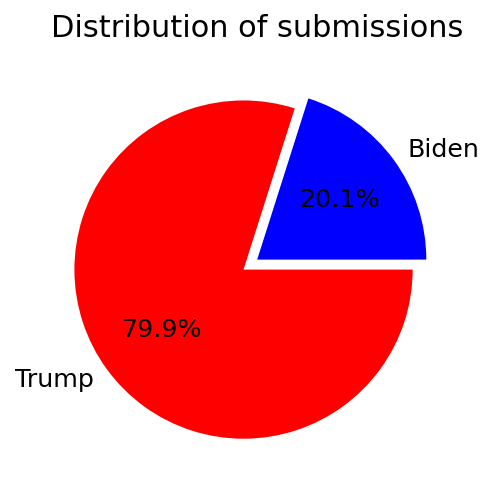

In [15]:
biden_trump_subs_dist = pd.DataFrame(sub_data.groupby("politician").count()["title"])
biden_trump_subs_dist = biden_trump_subs_dist.rename(columns = {"title" : " "})
#biden_trump_subs_dist
fig = plt.figure(dpi=140)
subs_dist_plot = biden_trump_subs_dist.plot.pie(y = " ", title = "Distribution of submissions", legend = False, colors = ["blue", "red"], shadow = False, autopct='%1.1f%%', explode=(0, 0.1), ax=plt.gca())
subs_dist_plot.figure.savefig("subs_distribution.png")

In [16]:
print("Total number of submissions: " + str(len(sub_data)))
print("Total number of submissions mentioning Trump: " + str(len(sub_data.loc[sub_data["politician"] == "Trump"])))
print("Total number of submissions mentioning Biden: " + str(len(sub_data.loc[sub_data["politician"] == "Biden"])))
print("Number of unique authors: " + str(len(sub_data["author"].unique())))
print("Average number of submissions per author: " + str(round(sub_data.groupby("author").count()["title"].mean(),2)))
print("Average number of comments per submission: " + str(round(sub_data["num_comments"].mean(), 1)))

Total number of submissions: 9018
Total number of submissions mentioning Trump: 7205
Total number of submissions mentioning Biden: 1813
Number of unique authors: 2912
Average number of submissions per author: 3.1
Average number of comments per submission: 150.5


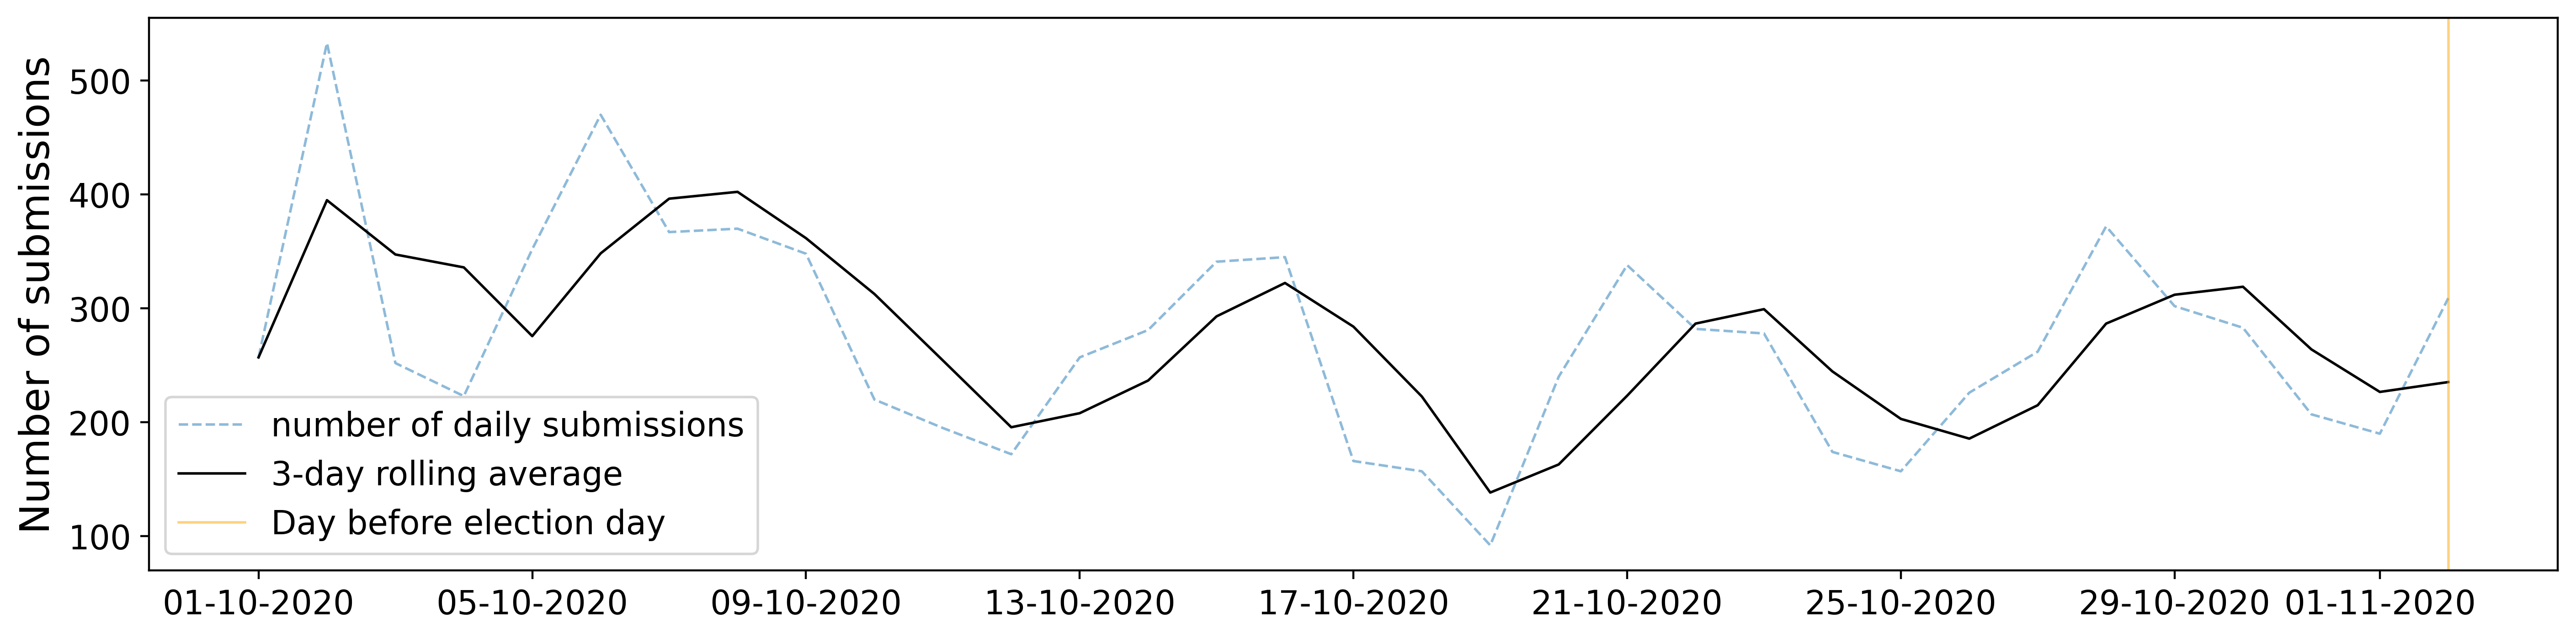

In [17]:
#We had some submissions befor the first of october
daily_subs = sub_data['id'].resample('D').count()
#Specifying the MatPlotLib font and line width
def setup_mpl():
    mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['font.size'] = '13'
    mpl.rcParams['lines.linewidth'] = 1
setup_mpl()
MyFmt = mdates.DateFormatter('%d-%m-%Y')
#Resample number of comments per day. 
#Convert to dataframe
daily_subs_df = pd.DataFrame(
                    {
                        'Daily submissions' : daily_subs.values
                    }, index = daily_subs.index)

MA_subs = daily_subs_df["Daily submissions"].rolling('3D').mean()
#Plot the moving average on top!

#fig, ax = plt.subplots(figsize=(15,5), dpi=400)
fig, ax = plt.subplots(figsize=(17,4), dpi=400)
ax.plot(daily_subs.index, daily_subs.values, ls = '--', alpha=0.5, label="number of daily submissions")
ax.plot(MA_subs.index, MA_subs.values, color='k', label="3-day rolling average")

ax.axvline(x=daily_subs.index[-1], label='Day before election day', color='orange', alpha=0.5)
#ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")
ax.set_ylabel('Number of submissions', size = 16)
#ax.set_yscale('log')
ax.legend()
ax.xaxis.set_major_formatter(MyFmt)

plt.savefig('submissions_per_day_big.png', bbox_inches='tight')

In [18]:
sub_data[:3].drop(columns=["score"])

title  \
dates                                                                    
2020-11-02 22:54:58  Trump ramps up Fauci attacks on eve of electio...   
2020-11-02 22:48:58  Trump Loves To Declare Victory Even if He Didn...   
2020-11-02 22:46:57  Trump creates 1776 Commission to promote 'patr...   

                         id              author  num_comments  \
dates                                                           
2020-11-02 22:54:58  jmybs3              geoxol            33   
2020-11-02 22:48:58  jmy7vu  Facerealityalready            16   
2020-11-02 22:46:57  jmy6j9          bluestblue            53   

                                                                   url  \
dates                                                                    
2020-11-02 22:54:58  https://thehill.com/homenews/administration/52...   
2020-11-02 22:48:58  https://www.motherjones.com/politics/2020/11/t...   
2020-11-02 22:46:57  https://www.politico.com/news/2020/11/02/trump...   

                    politician  
dates                           
2020-11-02 22:54:58      Trump  
2020-11-02 22:48:58      Trump  
2020-11-02 22:46:57      Trump

### Statistics of the comments

# 3 Tools, theory and analysis

In [21]:
# Implementing the VADER sentiment analysis of the comments. 

#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
def calculate_compound_sentiment_score(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # The Compound score is a metric that calculates the sum of all the lexicon ratings 
    # which have been normalized between -1(most extreme negative) and +1 (most extreme positive).   
    
    return sentiment_dict['compound']

In [22]:
tqdm.pandas()
com_data["compound_sentiment_score"] = com_data["body"].progress_apply(calculate_compound_sentiment_score)

100%|████████████████████████████████████████████████████████████████████████████| 95893/95893 [17:26<00:00, 91.64it/s]


In [33]:
#com_data.to_csv("politics_comments_big_with_sentiment.csv")

In [35]:
#com_data

In [23]:
test = com_data["body"][-2]
test = re.sub(r'\n', '', test)
test = re.sub(r'\'', '', test)
calculate_compound_sentiment_score('not bad good')
#test

0.1139

NOTE: Here, we've managed to delete even more comments leaving some authors with less than five comments. 

In [24]:
tqdm.pandas()
group = com_data.groupby(["author", "politician"])
#author_df_V = group.progress_apply(lambda x: x["compound_sentiment_score"].unique())


In [25]:
author_comments = group["body"].unique()
text = author_comments.values[0]

In [26]:
author_bodies = com_data.groupby(["author", "politician"]).apply(lambda x: x["body"].unique())

In [27]:
# Joining the comments for each politician for each of the authors
for i in tqdm(range(len(author_bodies.values))):
    author_bodies.values[i] = " ".join(list(author_bodies.values[i]))
    

100%|██████████████████████████████████████████████████████████████████████████| 3340/3340 [00:00<00:00, 119692.89it/s]


In [28]:
# List of unique comments authors
authors = list(com_data["author"].unique())

In [29]:
# Dict to contain the authors as keys and a dict as value: {"Biden" : compound sentiment score of the concatenated Biden-related comments, "Trump" : compound sentiment score of the concatenated Biden-related comments}
# Each list of sentiment scores contain 0 per default corresponding to a neutral compound sentiment. 
author_comment_sentiment_dict = {author : {"Biden" : 0, "Trump": 0} for author in authors}
for author in tqdm(authors):
    related_politicians = list(author_bodies[author].index)
    for politician in related_politicians:
        author_comment_sentiment_dict[author][politician] = calculate_compound_sentiment_score(author_bodies[author][politician])

100%|██████████████████████████████████████████████████████████████████████████████| 1741/1741 [04:47<00:00,  6.05it/s]


In [30]:
max(author_comment_sentiment_dict['cyanydeez'], key=author_comment_sentiment_dict['cyanydeez'].get)

'Biden'

In [31]:
author_conviction = pd.DataFrame({"author" : authors})

In [32]:
author_conviction["supporter_of"] = [max(author_comment_sentiment_dict[author], key=author_comment_sentiment_dict[author].get) for author in authors]
author_conviction

author supporter_of
0                yyungpiss        Biden
1             J_Class_Ford        Trump
2                cyanydeez        Biden
3                  Tesides        Biden
4         smurfsundermybed        Trump
...                    ...          ...
1736          fundropp8242        Biden
1737  TrumpVotersAre2Blame        Biden
1738  bleach_injector_2020        Biden
1739     FUCKLORD_SKYPUNCH        Biden
1740             muncher21        Biden

[1741 rows x 2 columns]

In [11]:
import requests 
import io
url_conviction = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/Saved dataframes etc/author_conviction_df.csv"

download_conviction = requests.get(url_conviction).content

author_conviction = pd.read_csv(io.StringIO(download_conviction.decode('utf-8')), parse_dates = ['Unnamed: 0'], sep=',').set_index('Unnamed: 0')
author_conviction.index = author_conviction.index.rename('index')
author_conviction

author supporter_of
index                                   
0                 yyungpiss        Biden
1              J_Class_Ford        Trump
2                 cyanydeez        Biden
3                   Tesides        Biden
4          smurfsundermybed        Trump
...                     ...          ...
1736     throwawaywriting12        Trump
1737           fundropp8242        Biden
1738   TrumpVotersAre2Blame        Trump
1739   bleach_injector_2020        Trump
1740              muncher21        Biden

[1741 rows x 2 columns]

In [6]:
url_com = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_comments_big_with_sentiment_newest.csv"

download_com = requests.get(url_com).content

com_data = pd.read_csv(io.StringIO(download_com.decode('utf-8')), parse_dates = ['dates'], sep=',').set_index('dates')
com_data

id    link_id  score           author   parent_id  \
dates                                                                         
2020-11-03 00:23:36  gaycvmz  t3_jmybs3      1        yyungpiss   t3_jmybs3   
2020-11-02 23:26:26  gay6kwb  t3_jmybs3      1     J_Class_Ford  t1_gay5x5w   
2020-11-02 23:20:27  gay5x5w  t3_jmybs3      1        cyanydeez  t1_gay5pjk   
2020-11-02 23:18:33  gay5pjk  t3_jmybs3      1     J_Class_Ford  t1_gay5doq   
2020-11-02 23:15:36  gay5doq  t3_jmybs3      1        cyanydeez  t1_gay3si8   
...                      ...        ...    ...              ...         ...   
2020-10-01 01:25:30  g78ozrz  t3_j2vwwt      1    5DollarHitJob   t3_j2vwwt   
2020-10-01 01:24:25  g78ovcd  t3_j2vwwt      1      AmishTechno   t3_j2vwwt   
2020-10-01 00:29:42  g78j6ey  t3_j2vwwt      1   ryhaltswhiskey  t1_g78iult   
2020-10-01 00:07:18  g78gwrv  t3_j2vwwt      1  GrumpyOlBastard   t3_j2vwwt   
2020-10-01 00:00:36  g78g8dl  t3_j2vwwt      1   maybe-fuck-you   t3_j2vwwt   

                                                                  body  \
dates                                                                    
2020-11-03 00:23:36  is there some sort of weird strategy to this o...   
2020-11-02 23:26:26                             Division is his weapon   
2020-11-02 23:20:27  dunno, everything trump does seems to generate...   
2020-11-02 23:18:33  Not sure it generates many more votes. I work ...   
2020-11-02 23:15:36  yeah, but for every vote this generates, would...   
...                                                                ...   
2020-10-01 01:25:30                         Can they just appeal this?   
2020-10-01 01:24:25                          And, nothing will happen.   
2020-10-01 00:29:42  Ah I did not know that\n\nMan I hope Barr ends...   
2020-10-01 00:07:18  So I’m wondering what’s going to happen when n...   
2020-10-01 00:00:36                              My report I paid for.   

                    parent_author  \
dates                               
2020-11-03 00:23:36        geoxol   
2020-11-02 23:26:26     cyanydeez   
2020-11-02 23:20:27  J_Class_Ford   
2020-11-02 23:18:33     cyanydeez   
2020-11-02 23:15:36  J_Class_Ford   
...                           ...   
2020-10-01 01:25:30    Plymouth03   
2020-10-01 01:24:25    Plymouth03   
2020-10-01 00:29:42   memepolizia   
2020-10-01 00:07:18    Plymouth03   
2020-10-01 00:00:36    Plymouth03   

                                                                tokens  \
dates                                                                    
2020-11-03 00:23:36  ['sort', 'weird', 'strategy', 'something', 'la...   
2020-11-02 23:26:26                             ['division', 'weapon']   
2020-11-02 23:20:27  ['dunno', 'everything', 'trump', 'seems', 'gen...   
2020-11-02 23:18:33  ['not', 'sure', 'generates', 'many', 'votes', ...   
2020-11-02 23:15:36  ['yeah', 'every', 'vote', 'generates', 'would'...   
...                                                                ...   
2020-10-01 01:25:30                                  ['can', 'appeal']   
2020-10-01 01:24:25                       ['and', 'nothing', 'happen']   
2020-10-01 00:29:42  ['ah', 'i', 'know', 'man', 'i', 'hope', 'barr'...   
2020-10-01 00:07:18  ['so', 'i', 'wondering', 'going', 'happen', 'n...   
2020-10-01 00:00:36                      ['my', 'report', 'i', 'paid']   

                    politician children_comments mentions_Trump  \
dates                                                             
2020-11-03 00:23:36      Trump                []            NaN   
2020-11-02 23:26:26      Trump                []            NaN   
2020-11-02 23:20:27      Trump       ['gay6kwb']           True   
2020-11-02 23:18:33      Trump       ['gay5x5w']           True   
2020-11-02 23:15:36      Trump       ['gay5pjk']            NaN   
...                        ...               ...            ...   
2020-10-01 01:25:30      Trump                []      

In [12]:
edges = com_data.drop(['id', 'link_id', 'parent_id','body','tokens','politician','children_comments','mentions_Trump', 'mentions_Biden', 'compound_sentiment_score'], axis=1)
edges = com_data.groupby(['author', 'parent_author']).count()
edges

id  link_id  score  parent_id  body  \
author              parent_author                                          
---------_----_---_ 1PositiveKarma1   1        1      1          1     1   
                    2wedfgdfgfgfg     1        1      1          1     1   
                    66fenderjazz      1        1      1          1     1   
                    ANTristotle       1        1      1          1     1   
                    AmishAvenger      1        1      1          1     1   
...                                  ..      ...    ...        ...   ...   
zubbs99             westondeboer      1        1      1          1     1   
                    wrapityup         1        1      1          1     1   
                    wrldtrvlr3000     1        1      1          1     1   
                    xTemporaneously   1        1      1          1     1   
                    zztop610          1        1      1          1     1   

                                     tokens  politician  children_comments  \
author              parent_author                                            
---------_----_---_ 1PositiveKarma1       1           1                  1   
                    2wedfgdfgfgfg         1           1                  1   
                    66fenderjazz          1           1                  1   
                    ANTristotle           1           1                  1   
                    AmishAvenger          1           1                  1   
...                                     ...         ...                ...   
zubbs99             westondeboer          1           1                  1   
                    wrapityup             1           1                  1   
                    wrldtrvlr3000         1           1                  1   
                    xTemporaneously       1           1                  1   
                    zztop610              1           1                  1   

                                     mentions_Trump  mentions_Biden  \
author              parent_author                                     
---------_----_---_ 1PositiveKarma1               0               0   
                    2wedfgdfgfgfg                 0               0   
                    66fenderjazz                  0               0   
                    ANTristotle                   0               0   
                    AmishAvenger                  0               0   
...                                             ...             ...   
zubbs99             westondeboer                  0               0   
                    wrapityup                     0               0   
                    wrldtrvlr3000                 0               0   
                    xTemporaneously               0               0   
                    zztop610                      0               0   

                                     compound_sentiment_score  
author              parent_author                              
---------_----_---_ 1PositiveKarma1                         1  
                    2wedfgdfgfgfg                           1  
                    66fenderjazz                            1  
                    ANTristotle                             1  
                    AmishAvenger                            1  
...                                                       ...  
zubbs99             westondeboer                            1  
                    wrapityup                               1  
                    wrldtrvlr3000                           1  
                    xTemporaneously                         1  
                    zztop610                                1  

[86546 rows x 11 columns]

In [339]:
# We make a directed graph. 
edges = com_data.drop(['id', 'link_id', 'parent_id','body','tokens','politician','children_comments','mentions_Trump', 'mentions_Biden', 'compound_sentiment_score'], axis=1)
edges = com_data.groupby(['author', 'parent_author']).count()
#print(edges)
#print(edges.loc[edges['author'] == 'yyungpiss'])

G = nx.DiGraph()

# Add all edges and remake to reciprocal.

G.add_weighted_edges_from([ (a, b, edges['score'].loc[(a,b)]) for a, b in edges.index])                           
#G = nx.path_graph(10)
#G.add_edges_from((a,b) for a,b in edges.index)

G_U = G.to_undirected(reciprocal=True)

for node, ngbr, w in G_U.edges.data('weight'):
#     Undirected edge weights equal to sum of weights in two corresponding directed edges
    G_U.edges[node, ngbr]['weight'] = (G.edges[node, ngbr]['weight'] + G.edges[ngbr, node]['weight'])

# Finally, remove isolated nodes and self-loops in graph.
G_U.remove_edges_from(nx.selfloop_edges(G_U))

G_U.remove_nodes_from(list(nx.isolates(G_U))) 

Original_G_U_edges = G_U.edges()


print('Nodes: {}'.format(G_U.number_of_nodes()))
print('Edges: {}'.format(G_U.number_of_edges()))



Nodes: 1511
Edges: 3866


In [340]:
#edges.loc[edges['score'] > 1]
#list(author_conviction.loc[author_conviction['author'] == 'yyungpiss']['supporter_of'].values)[0]
#G_U.nodes['BurtonDesque']
node_list = list(G_U.nodes())
print(len(node_list))
len(G_U.nodes())

1511


1511

In [341]:
author_list = list(author_conviction['author'].values)
author_list

['yyungpiss',
 'J_Class_Ford',
 'cyanydeez',
 'Tesides',
 'smurfsundermybed',
 'Searchlights',
 'forumer101',
 'radiofever',
 'danielbot',
 'HereForAnArgument',
 'DribCC',
 'ghintziest',
 'veridique',
 '000882622',
 'uping1965',
 'djheat',
 'LockheedMartinLuther',
 'bigturbine',
 'gasahold',
 'Braintendo',
 'WittsandGrit',
 'Vegetable_Employee',
 'BroadAsparagus',
 '4quatloos',
 '_MentosTheFreshmaker',
 'Limberine',
 'Wattsferatu',
 'Subliminal_Kiddo',
 'FrigginTommyNoble',
 'King_Mierdas',
 'BlueSwoosh248',
 'petrilstatusfull',
 'WishOneStitch',
 'hicow',
 'Tigger_king',
 'Moscowmitchismybitch',
 'sthlmsoul',
 '12characters',
 'tuctrohs',
 'skellener',
 'trogdor1234',
 'GhettoChemist',
 'InsertCocktails',
 'HelenHerriot',
 'mrkramer1990',
 'fence_sitter',
 'ColemansMillions',
 'Abs0lutE__zer0_',
 'perspective2020',
 'S28E01_The_Sequel',
 '7daykatie',
 'Meta_Digital',
 'BuyNanoNotBitcoin',
 'hawkseye17',
 'supes1',
 'Kay312010',
 'kickstarterscience',
 'sebb1976',
 'The_Kraken_Wakes',


In [342]:
author_list = list(author_conviction['author'].values)

#len(G.nodes())

node_list = list(G_U.nodes())


#G.nodes[0]

for i in tqdm(range(len(node_list))): 
    if node_list[i] in author_list: 
#        print(node_list[i])
 #       print(list(author_conviction.loc[author_conviction['author'] == node_list[i]]['supporter_of'].values)[0])
        G_U.nodes[node_list[i]]['conviction'] = list(author_conviction.loc[author_conviction['author'] == node_list[i]]['supporter_of'].values)[0]
  #      print(G_U.nodes[node_list[i]])
    else: 
        G_U.nodes[node_list[i]]['conviction'] = 'Unknown'
#list(author_conviction.loc[author_conviction['author'] == 'yyungpiss']['supporter_of'].values)[0]
#G_U.nodes['---------_----_---_']['room']

#G.edges['66fenderjazz','Facerealityalready']['weight']
#edges['66fenderjazz']
#edges.index
#com_data.loc[com_data['parent_author'] == '66fenderjazz']

100%|████████████████████████████████████████████████████████████████████████████| 1511/1511 [00:00<00:00, 2330.83it/s]


In [343]:
#values_list = list(G_U.nodes.values())

#for i in range(len(values_list)): 
 #   if values_list[i]['conviction'] == 'Unknown': 
  #      print('undecided user')

In [344]:
interactions_with_likeminded_users = []

node_list = list(G_U.nodes())

for i in tqdm(range(len(node_list))):
    
    own_conviction = G_U.nodes[node_list[i]]['conviction']

    neighbor_list = [n for n in G_U.neighbors(node_list[i])]
    for neighbor in neighbor_list: 
        neighbor_conviction = G_U.nodes[neighbor]['conviction']
        if neighbor_conviction == own_conviction: 
            interactions_with_likeminded_users.append(1)
        else: 
            interactions_with_likeminded_users.append(0)
len(interactions_with_likeminded_users)
        

100%|██████████████████████████████████████████████████████████████████████████| 1511/1511 [00:00<00:00, 168342.59it/s]


7732

In [345]:
interactions_with_likeminded_users = np.array(interactions_with_likeminded_users)
interactions_with_likeminded_users_mean = np.mean(interactions_with_likeminded_users)
interactions_with_likeminded_users_mean

0.5543197102948785

In [346]:
for i in tqdm(range(len(node_list))):
    conviction = G_U.nodes[node_list[i]]['conviction']
    if conviction == 'Trump':
        G_U.nodes[node_list[i]]['color'] = '#FF0000'
    if conviction == 'Biden':
        G_U.nodes[node_list[i]]['color'] = '#0000FF'

        


#G_U_C = G_U.copy()
#for n in G_U.nodes(data=False):
#    _col = '#%02x%02x%02x' % tuple(list([int(255*_) for _ in degree_scale[n][:3]]))
#   FBC.node[n]['color'] = _col

100%|██████████████████████████████████████████████████████████████████████████| 1511/1511 [00:00<00:00, 504786.41it/s]


In [347]:
#import networkx as nx; 

#nx.write_gexf(G_U, 'politics_network_correct.gexf')



In [348]:
largest_degree_labels = []
largest_degree_nodes = sorted(G_U.degree, key=lambda x: x[1], reverse=True)[:8]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])
largest_degree_labels

['Enjolras55',
 'PetGodzilla',
 'DezV',
 'ImInterested',
 'uping1965',
 'AlternativeSuccotash',
 'MBAMBA3',
 'southpawFA']

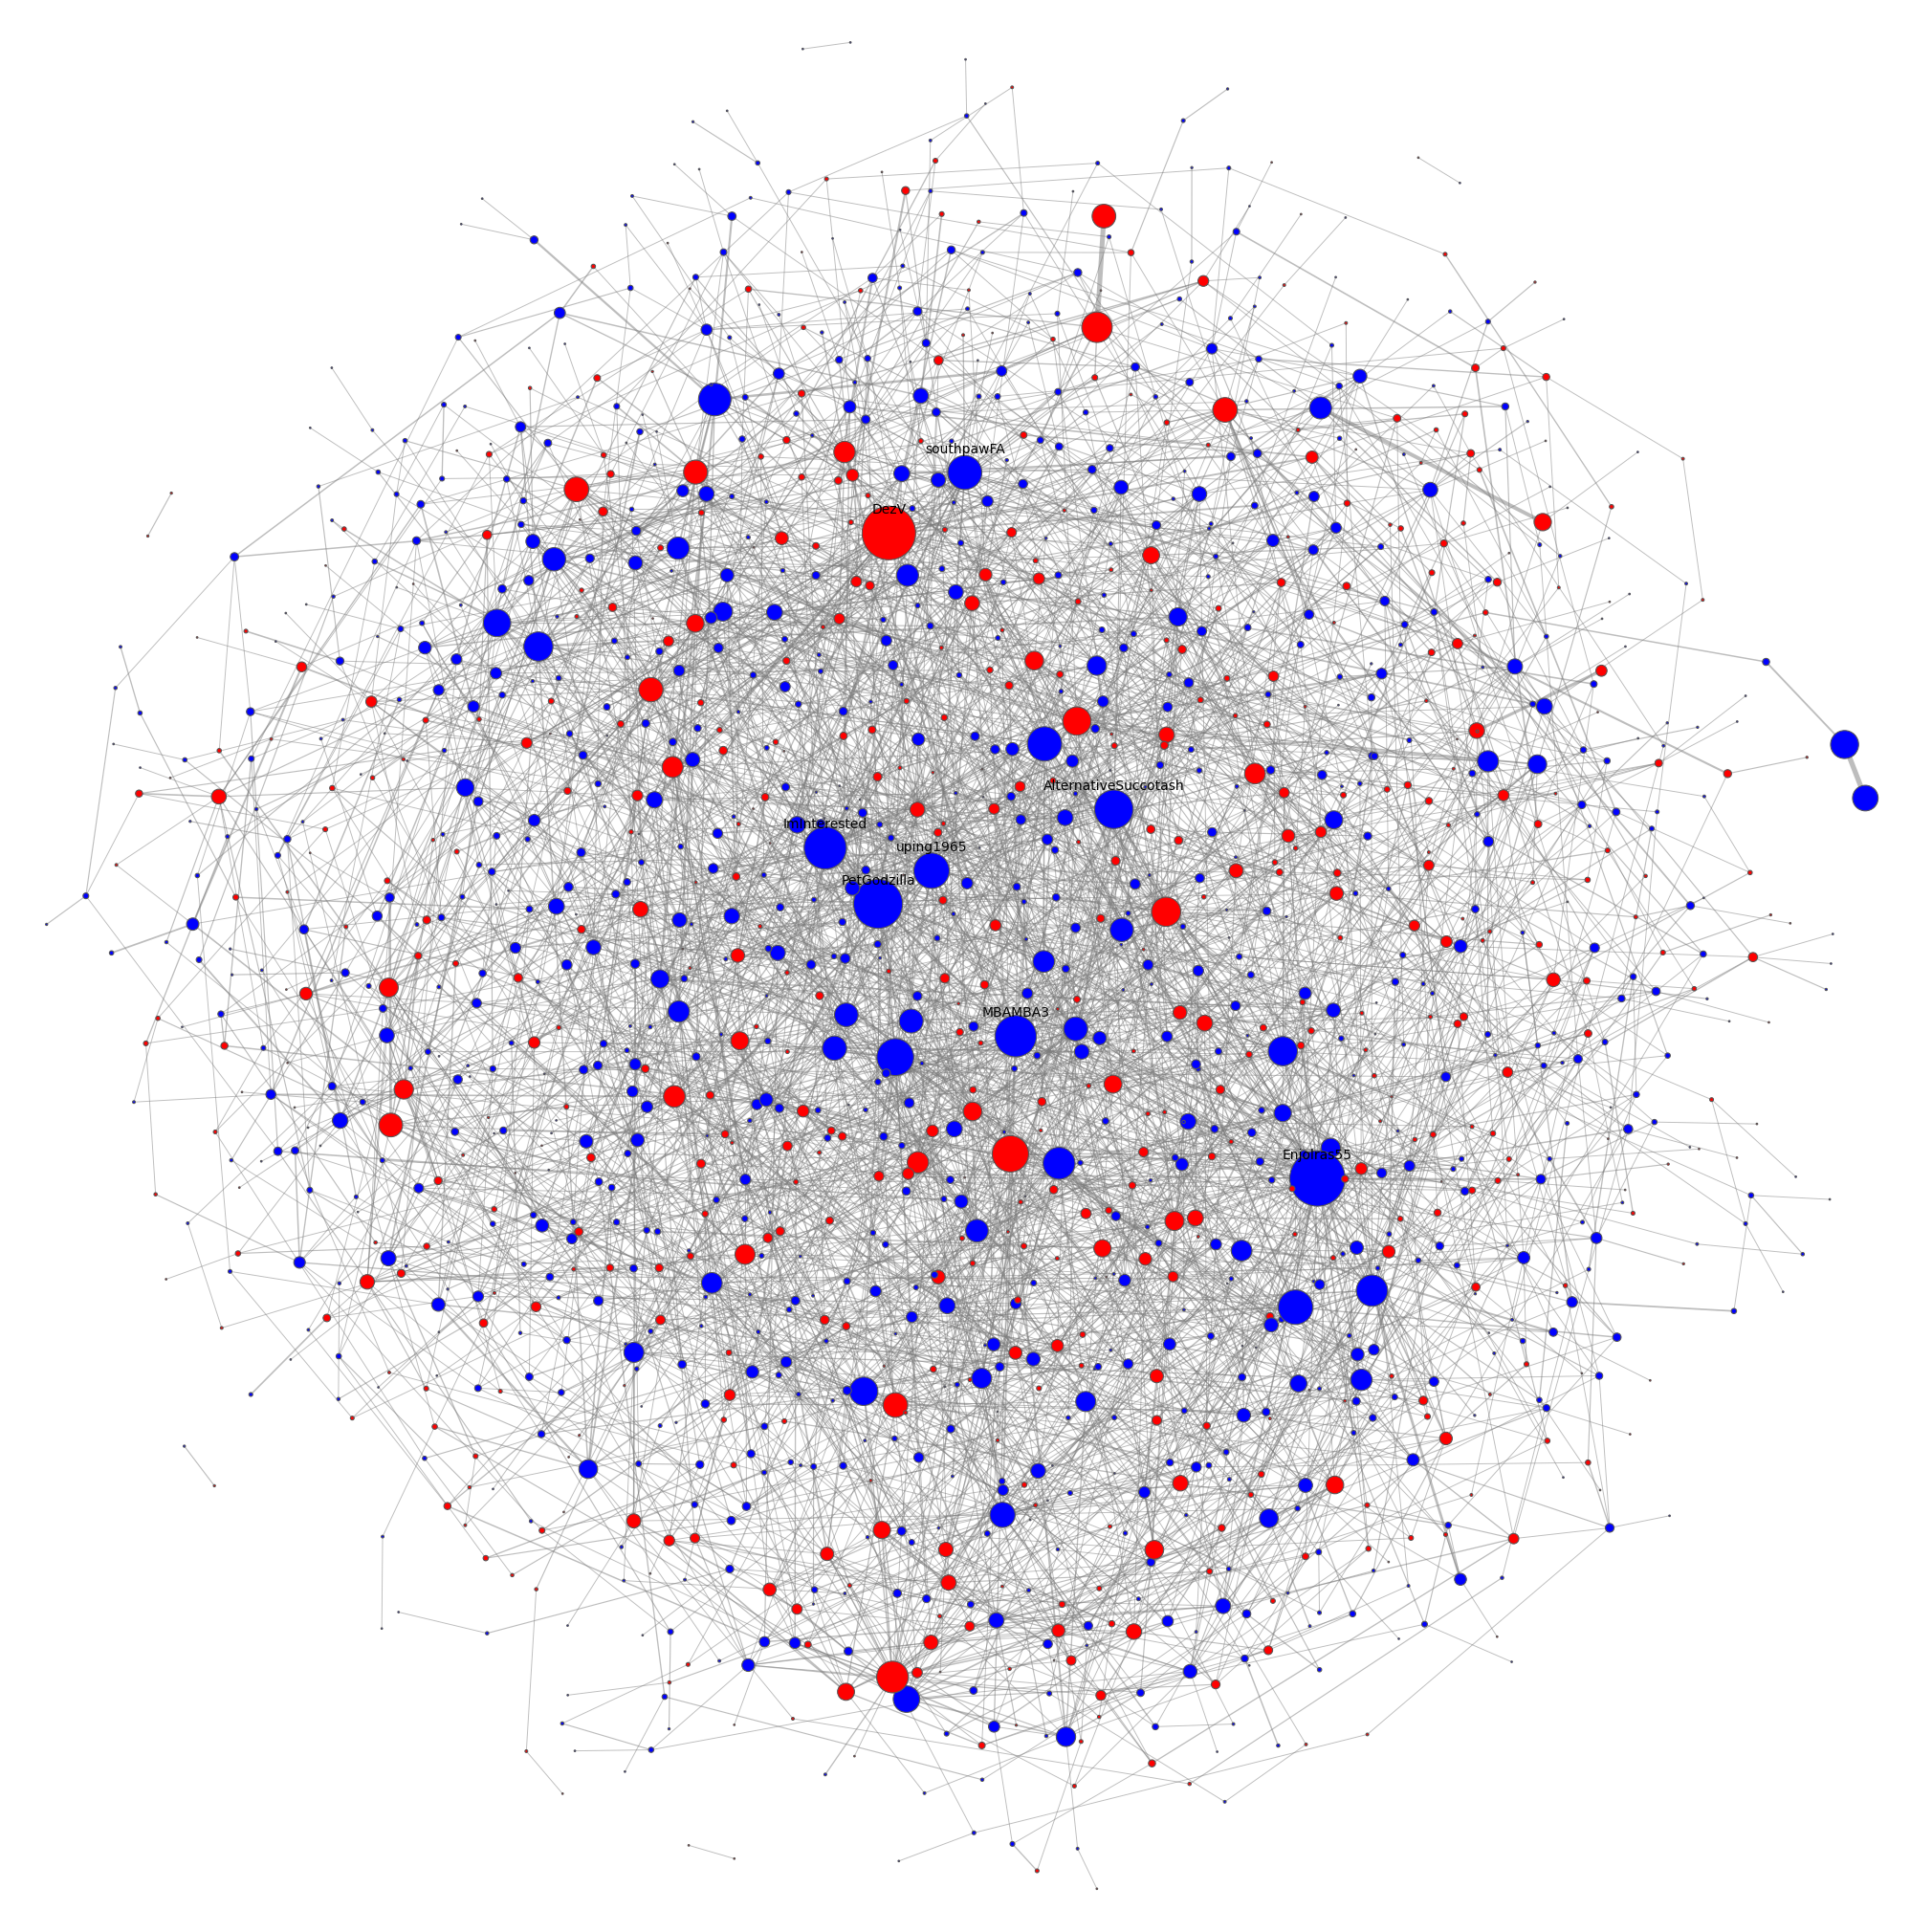

In [143]:
#nx.write_gexf(G_U, "com_network.gexf")

#G_U = nx.read_gexf("com_network.gexf")

plt.style.use('default')


configuration = {"zoom": 1.1, "node_charge": -30, "node_gravity": 0.4,
                 "link_distance": 15, "link_distance_variation": 0, "node_collision": True,
                 "wiggle_nodes": False, "freeze_nodes": False,
                 "node_fill_color": '#79aaa0', "node_stroke_color": "#555555",
                 "node_label_color": "#000000","node_size": 10,"node_stroke_width": 0.4,
                 "node_size_variation": 0.8, "label_size": 10, "display_node_labels": False,
                 "scale_node_size_by_strength": True,"link_color": "#7c7c7c", "link_width": 2,
                 "link_alpha": 0.5, "link_width_variation": 0.5, "display_singleton_nodes": True,
                 "min_link_weight_percentile": 0,"max_link_weight_percentile": 1}


network, config = nw.visualize(G_U, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 20)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 10)
    
plt.savefig('politics_network.png', bbox_inches='tight')

#with plt.style.context('classic'):
 #  network, config = nw.interactive.visualize(nw.get_filtered_network(G_U, node_group_key='conviction'),  plot_in_cell_below=False)
  # fig, ax = nw.draw_netwulf(network, config = configuration)


In [349]:
L = len(G_U.edges)
N = len(G_U.nodes)
p = 2*L/(N*(N-1))
print(f'p={p * 100:.2f}%')
k = 2*L/N
print('k: {:.3f}'.format(k))

p=0.34%
k: 5.117


In [350]:
Random_graph = nx.generators.random_graphs.erdos_renyi_graph(N,p)

minDeg: 0 | maxDeg: 14


Text(0.5, 0, 'degrees')

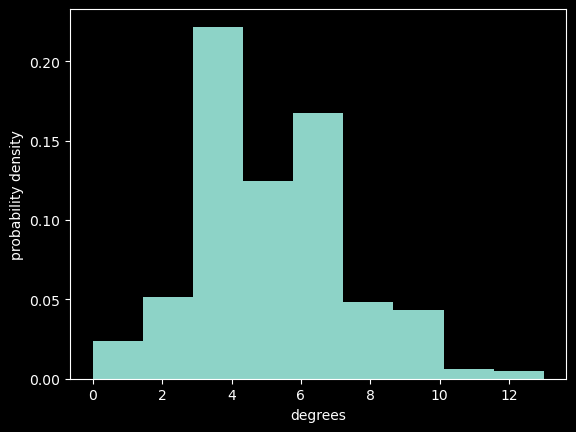

In [351]:
#Degree distribution for random network:

degrees = [x[1] for x in Random_graph.degree]
print('minDeg: {} | maxDeg: {}'.format(min(degrees), max(degrees)))
bins = np.linspace(0, 13, 10)
hist, edges = np.histogram(degrees, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.bar(x, hist, width=width)
ax.set_ylabel("probability density")
ax.set_xlabel("degrees")

minDeg: 1 | maxDeg: 57


Text(0.5, 0, 'degrees')

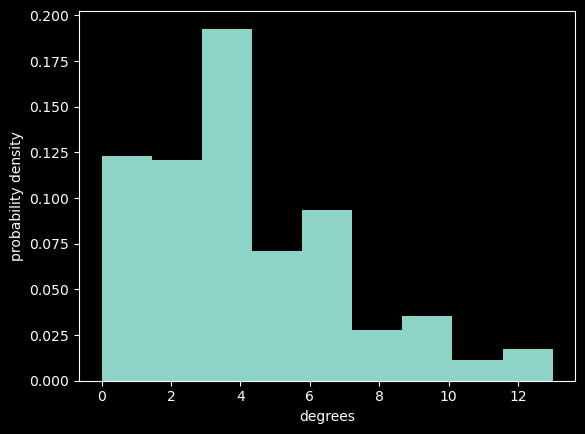

In [352]:
#Degree distribution for random network:

degrees = [x[1] for x in G_U.degree]
print('minDeg: {} | maxDeg: {}'.format(min(degrees), max(degrees)))
bins = np.linspace(0, 13, 10)
hist, edges = np.histogram(degrees, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.bar(x, hist, width=width)
ax.set_ylabel("probability density")
ax.set_xlabel("degrees")

minDeg: 1 | maxDeg: 57


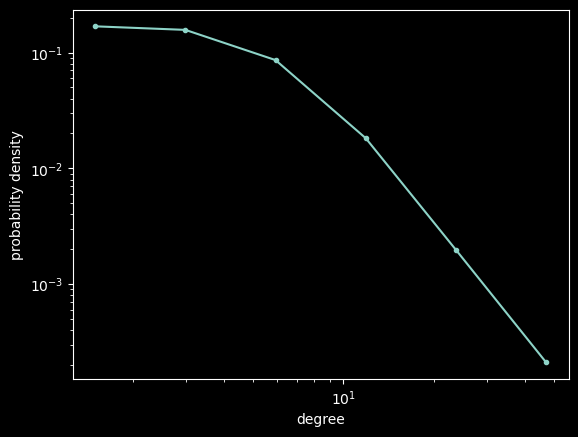

In [353]:
#Degree distribution for the reddit network:
degReddit = [x[1] for x in G_U.degree]
print('minDeg: {} | maxDeg: {}'.format(min(degReddit), max(degReddit)))
bins_reddit = np.logspace(0, np.log10(498), 10)
hist_reddit, edges_reddit = np.histogram(degReddit, bins=bins_reddit, density=True)
x_reddit = (edges_reddit[1:]+edges_reddit[:-1])/2
fig, ax = plt.subplots()
xx, yy = zip(*[(i,j) for (i,j) in zip(x_reddit, hist_reddit) if j > 0])
ax.plot(xx, yy, marker='.')
ax.set_ylabel("probability density")
ax.set_xlabel("degree")
ax.set_yscale('log')
ax.set_xscale('log')


In [354]:
trump = {key for (key, value) in dict(nx.get_node_attributes(G_U, "conviction")).items() if value == 'Trump'}
biden = {key for (key, value) in dict(nx.get_node_attributes(G_U, "conviction")).items() if value == 'Biden'}
#print(trump)
#print(biden)
G_U_modularity = round(nx_comm.modularity(G_U, [trump, biden]),5)
#round(modularity(G_U, [trump, biden]),5), 
G_U_copy = G_U

print(G_U_copy)
print(G_U_copy == G_U)
print(G_U.edges() == G_U_copy.edges())

G_U_modularity
#At fordele dem vha. politiske holdninger svarer næsten til random



Graph with 1511 nodes and 3866 edges
True
True


0.01932

In [355]:
G_U = G_U_copy

print(Original_G_U_edges == G_U.edges())

print(G_U.edges() == G_U_copy.edges())

partition = community_louvain.best_partition(G_U, random_state = 42)
partition_dict = {item: set() for (key, item) in partition.items()}
#partition_dict # There are 4 communities given louvain
# For Louvain vs Our own
for (key, item) in partition.items():
    partition_dict[item].add(key)
louvain_modularity = nx_comm.modularity(G_U, list(partition_dict.values()))
print(len(partition_dict))
louvain_modularity

#Meget højere modularity end ved Rep/Dem split

True
True
28


0.5313487751593329

In [ ]:
G_U = G_U_copy

H_U = nx.subgraph(G_U, list(partition_dict[1]))
H_U

largest_degree_labels = []
largest_degree_nodes = sorted(H_U.degree, key=lambda x: x[1], reverse=True)[:3]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])

plt.style.use('default')

network, config = nw.visualize(H_U, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 20)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 10)



----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 64727)
Traceback (most recent call last):
  File "C:\Shared\anaconda3\lib\http\server.py", line 705, in send_head
    f = open(path, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ejer\\.netwulf\\favicon.ico'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Shared\anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Shared\anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Shared\anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Shared\anaconda3\lib\http\server.py", line 647, in __init__
    super().__init__(*args, **kwargs)
  File "C:\Shared\anaconda3\lib\sockets

In [325]:
#STATISTISK TEST PÅ TRUMP/BIDEN SPLIT

random_kcnets = []
n = 1000
for _ in tqdm(range(n)):
    G_new = nx.double_edge_swap(G_U, nswap = G_U.number_of_edges(),max_tries = G_U.number_of_edges()*100) 
    random_kcnets.append(nx_comm.modularity(G_new, [trump, biden]))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.03it/s]


In [326]:
print('Avg. Modularity: {} \nStandard deviation: {}'.format(round(np.mean(random_kcnets),6), round(np.std(random_kcnets),6)))

Avg. Modularity: -0.000732 
Standard deviation: 0.007083


In [327]:
nx_comm.modularity(G_U, [trump, biden])

-0.0009415590411211705

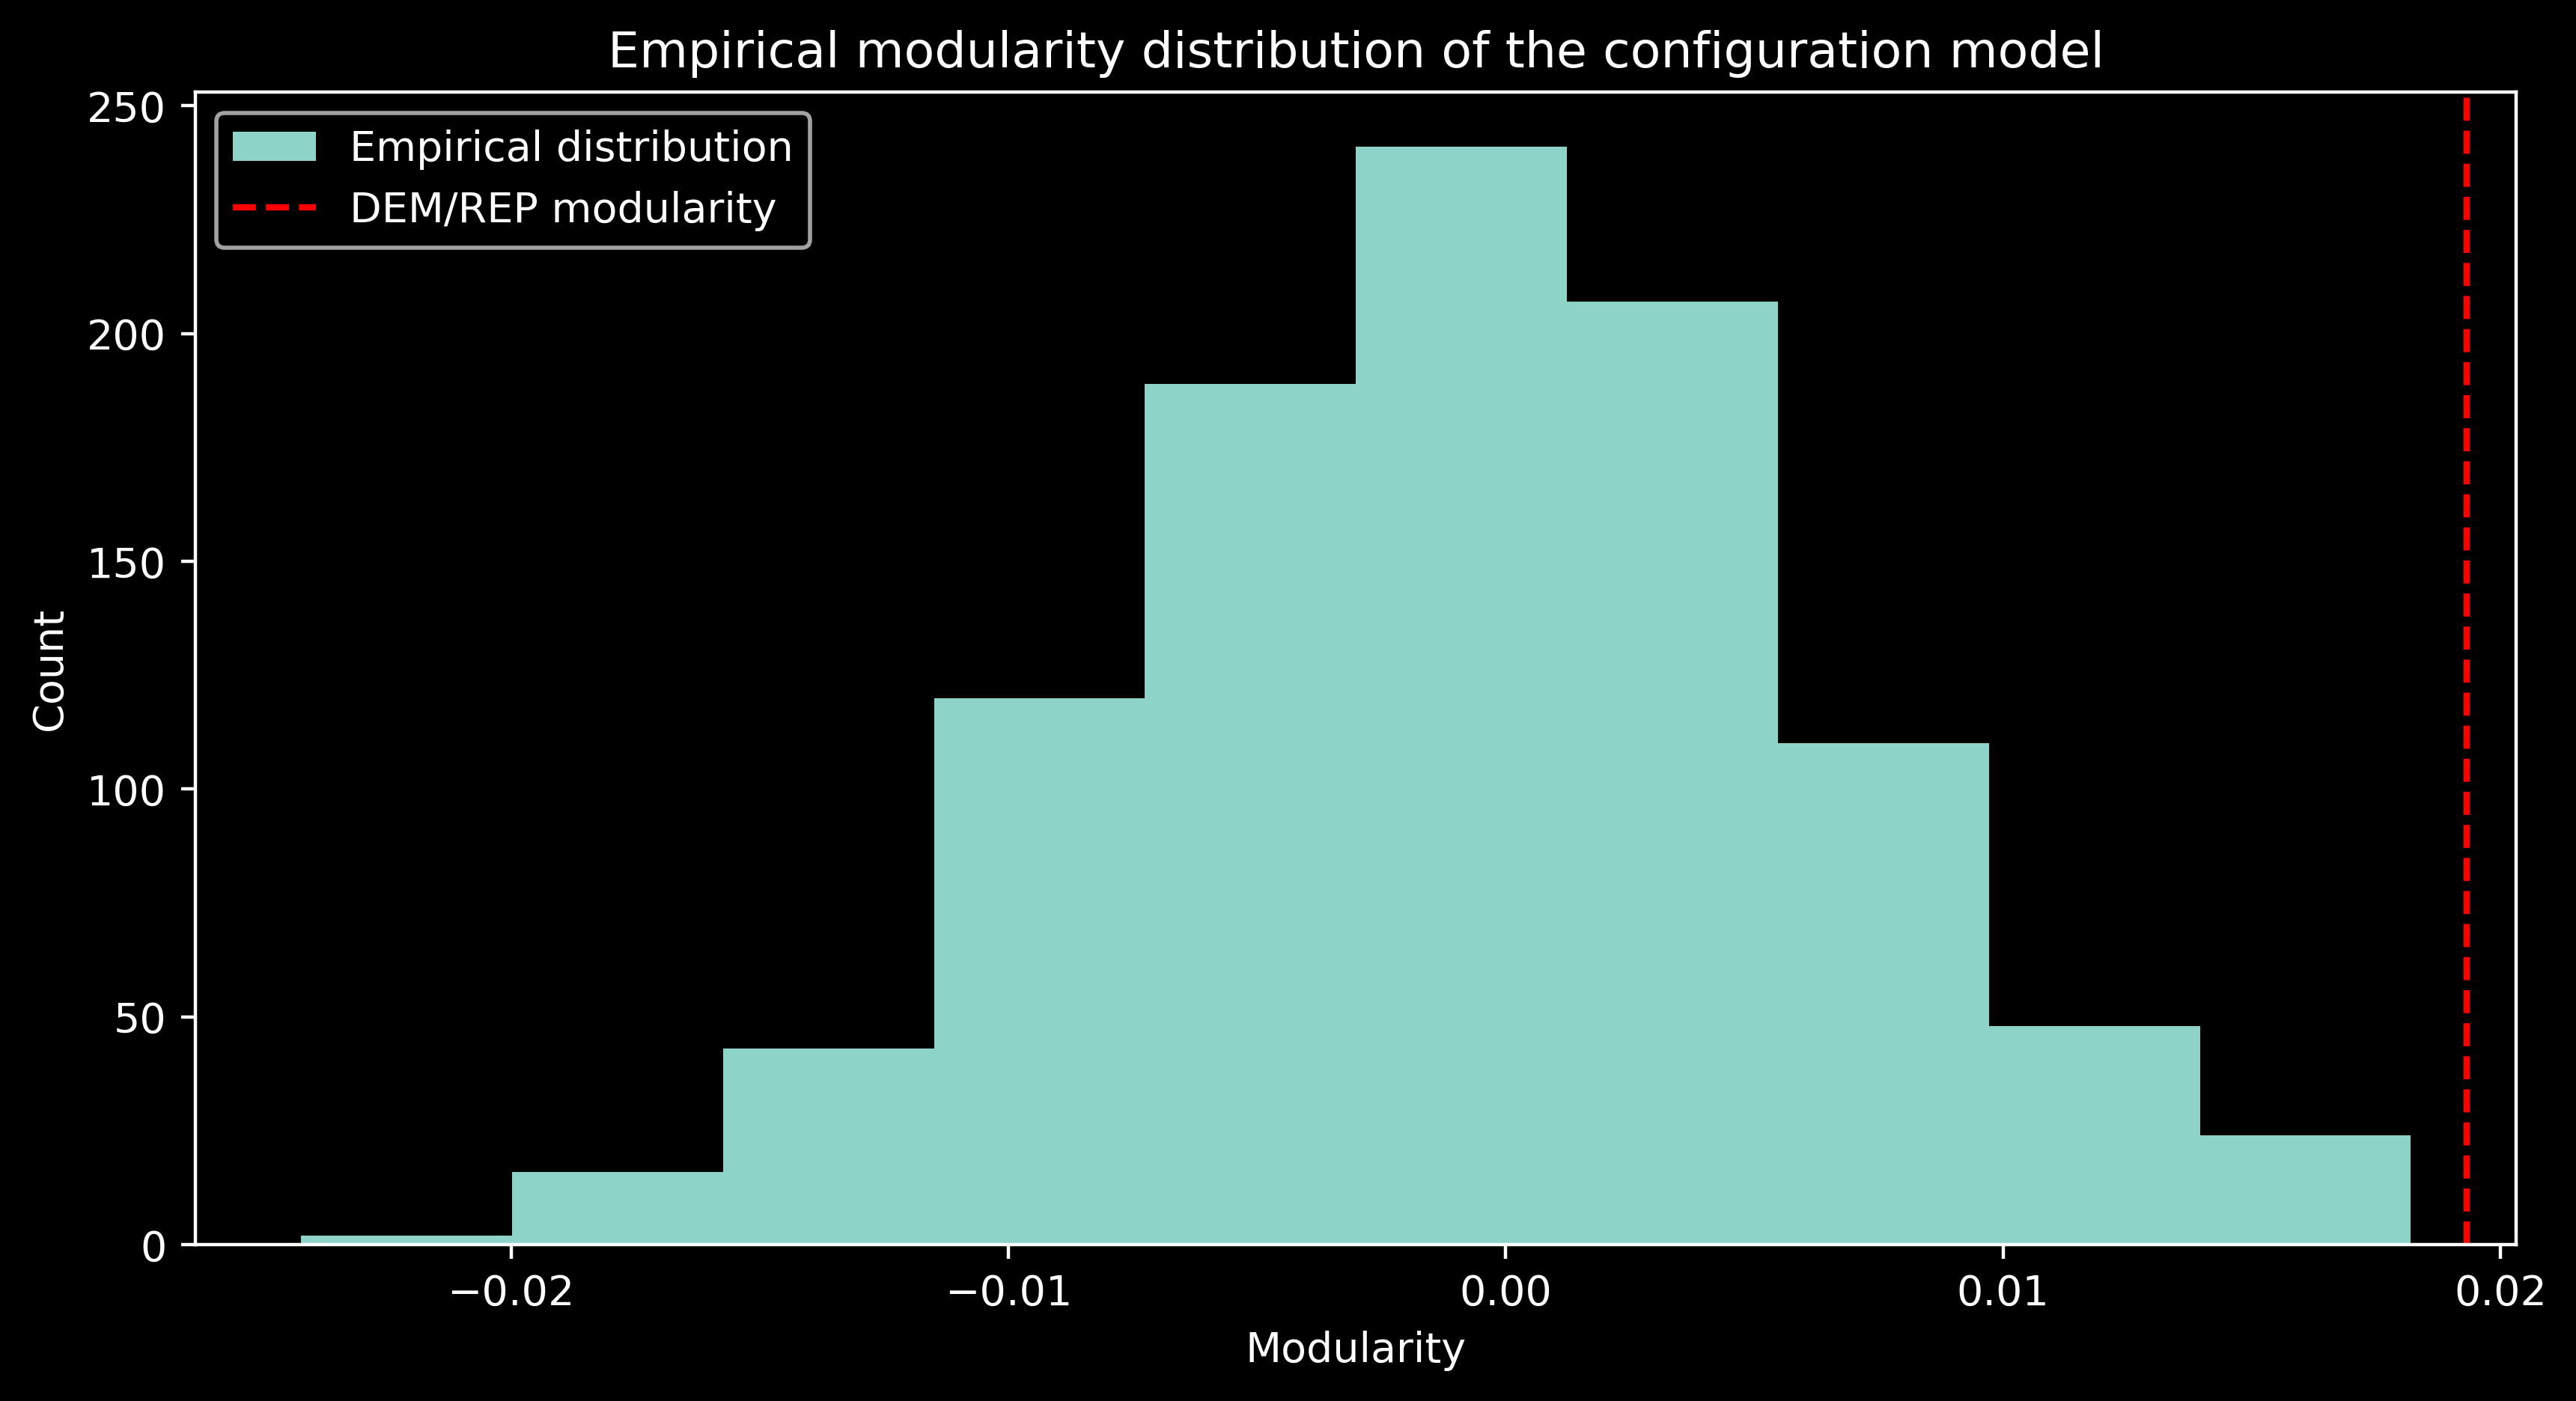

In [328]:
fig, ax = plt.subplots(figsize=(10,5), dpi=400)
ax.hist(random_kcnets, label="Empirical distribution", bins=10)
ax.axvline(G_U_modularity, linestyle='--', color='r', label="DEM/REP modularity")
ax.set_title("Empirical modularity distribution of the configuration model")
ax.set_ylabel("Count")
ax.set_xlabel("Modularity")
ax.legend()

In [335]:
G_U = G_U_copy

print(Original_G_U_edges == G_U.edges())

print(G_U.edges() == G_U_copy.edges())

partition = community_louvain.best_partition(G_U, random_state = 42)
partition_dict = {item: set() for (key, item) in partition.items()}
#partition_dict # There are 4 communities given louvain
# For Louvain vs Our own
for (key, item) in partition.items():
    partition_dict[item].add(key)
louvain_modularity = nx_comm.modularity(G_U, list(partition_dict.values()))
print(len(partition_dict))
louvain_modularity

#Meget højere modularity end ved Rep/Dem split

True
True
22


0.4372756416518287

In [336]:
#STATISTISK TEST PÅ LOVAIN SPLIT

random_kcnets = []
n = 1000
for _ in tqdm(range(n)):
    G_new = nx.double_edge_swap(G_U, nswap = G_U.number_of_edges(),max_tries = G_U.number_of_edges()*100) 
    random_kcnets.append(nx_comm.modularity(G_new, list(partition_dict.values())))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.69it/s]


In [331]:
print('Avg. Modularity: {} \nStandard deviation: {}'.format(round(np.mean(random_kcnets),6), round(np.std(random_kcnets),6)))

Avg. Modularity: -0.001227 
Standard deviation: 0.004071


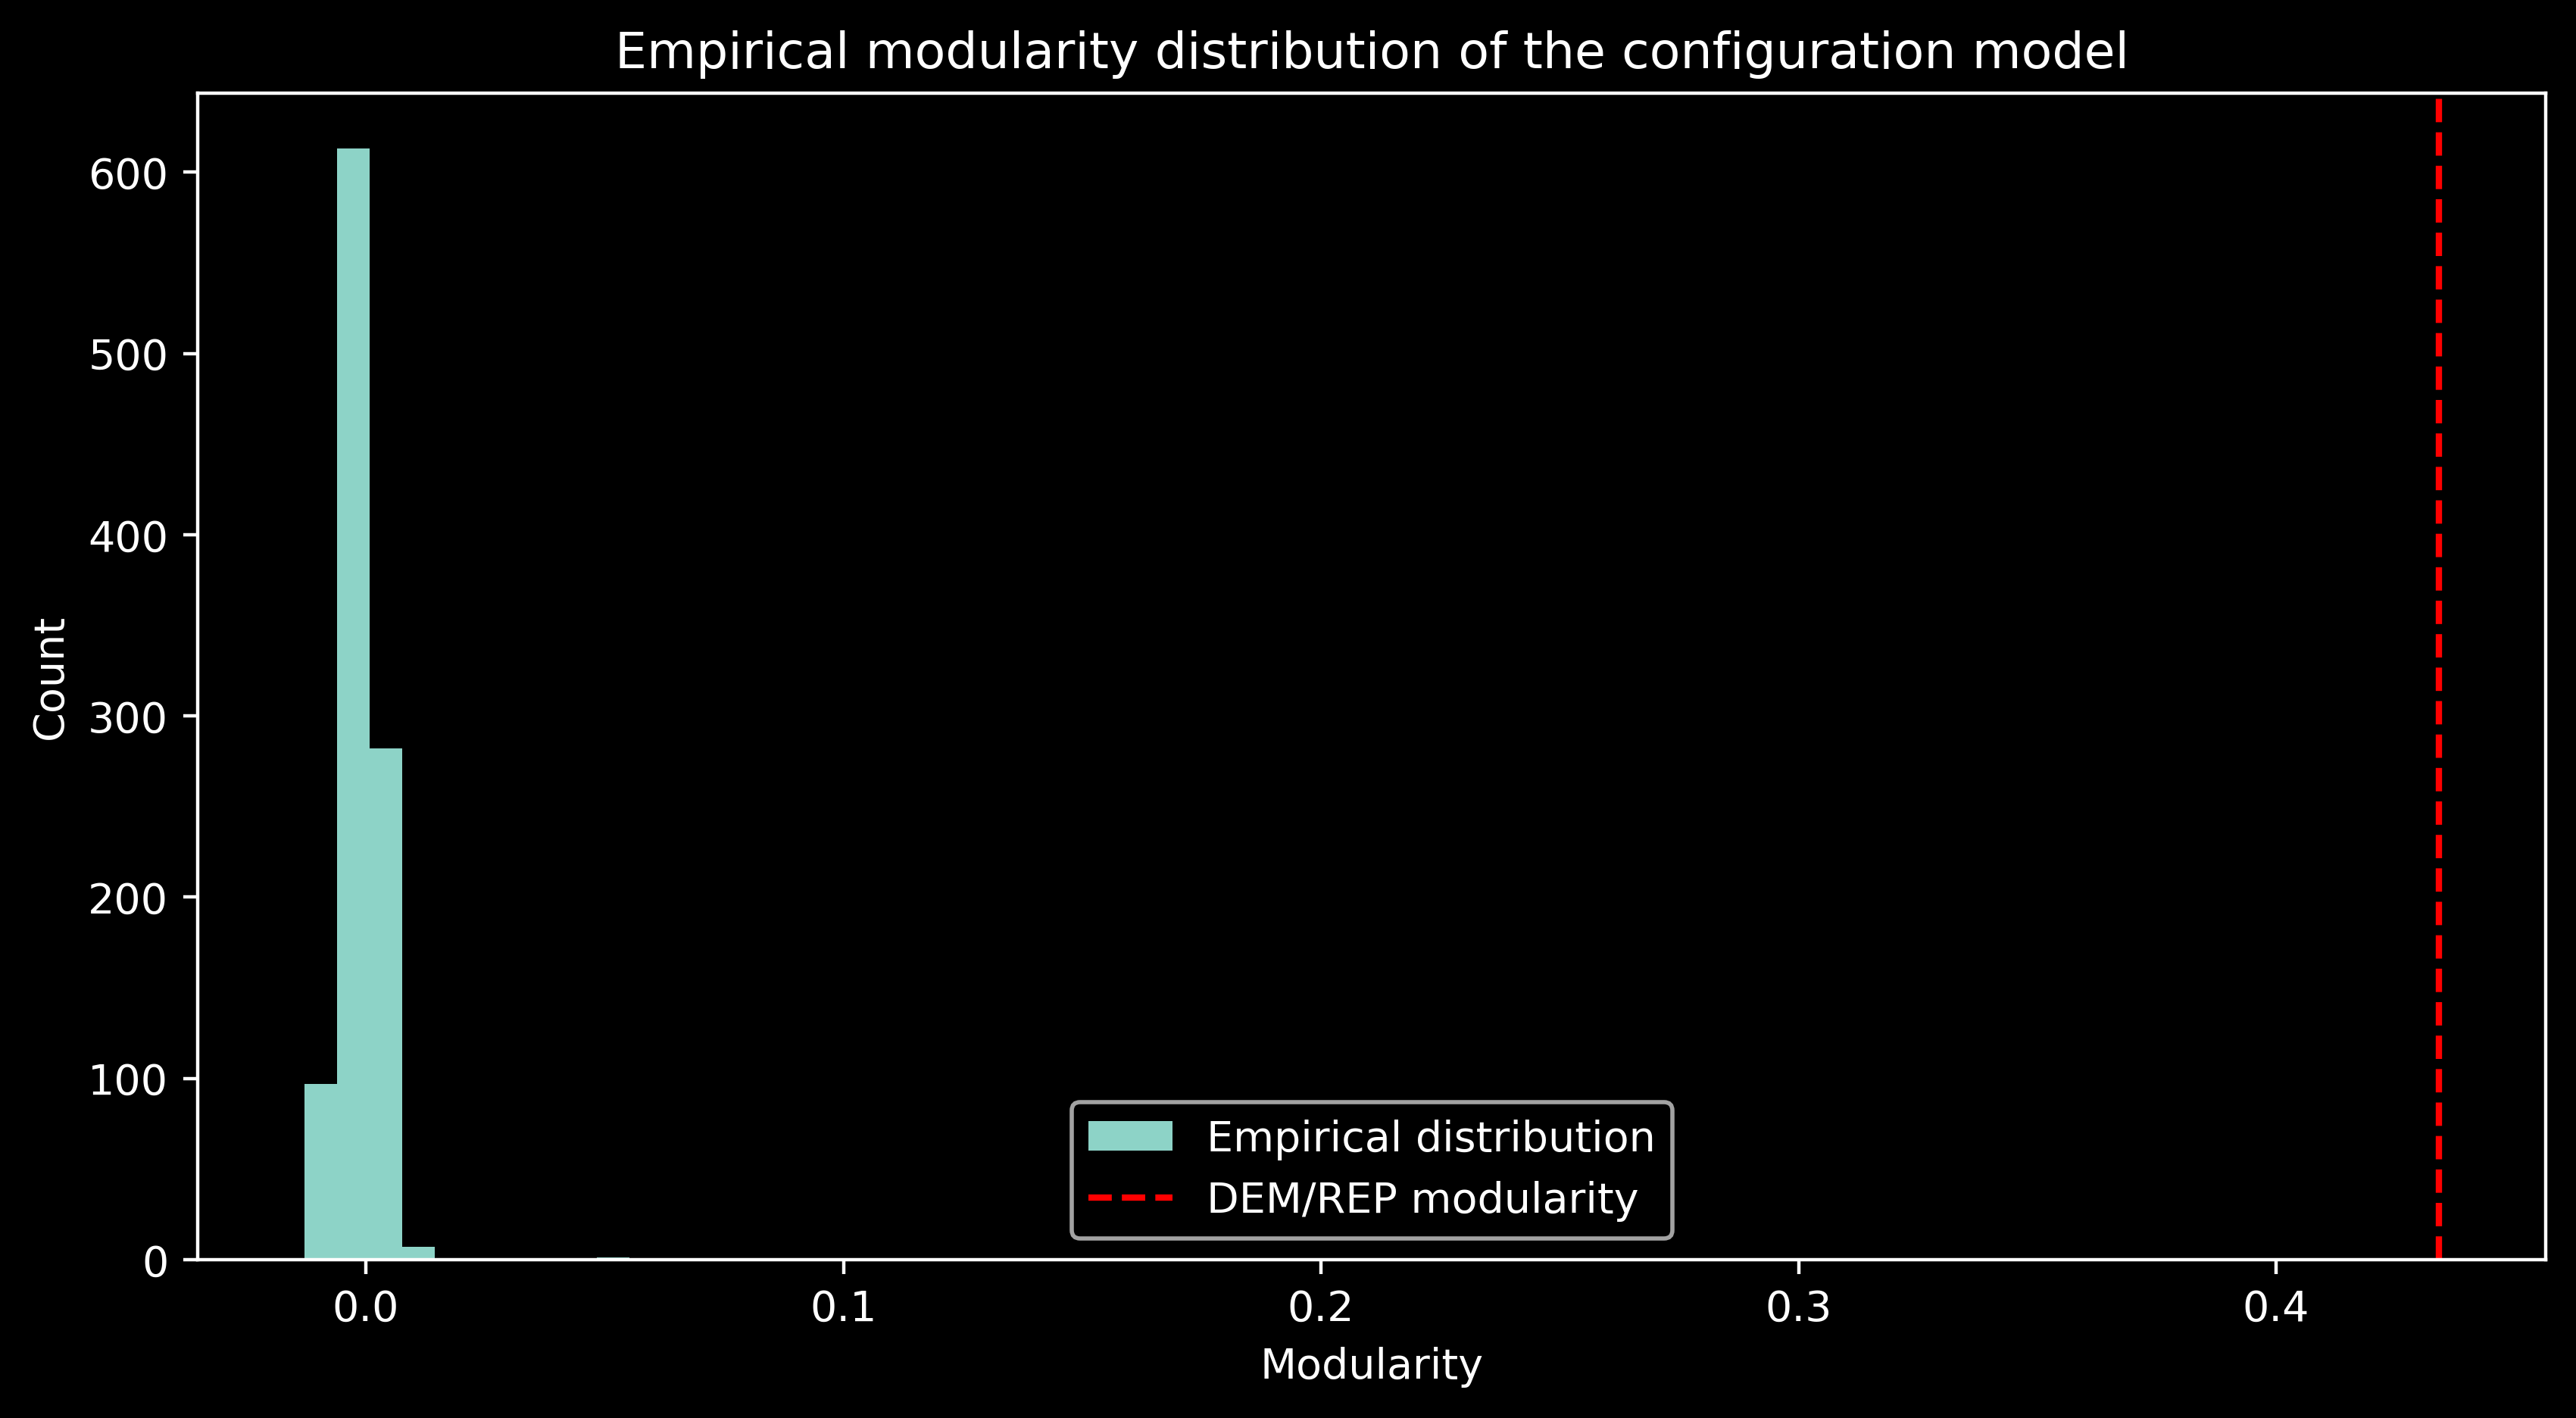

In [332]:
fig, ax = plt.subplots(figsize=(10,5), dpi=400)
ax.hist(random_kcnets, label="Empirical distribution", bins=10)
ax.axvline(louvain_modularity, linestyle='--', color='r', label="DEM/REP modularity")
ax.set_title("Empirical modularity distribution of the configuration model")
ax.set_ylabel("Count")
ax.set_xlabel("Modularity")
ax.legend()

In [334]:
print(G_U.edges == Original_G_U_edges)
len(partition_dict)
for i in range(len(partition_dict)): 
    print(len(partition_dict[i]))

True
112
120
2
2
73
53
113
80
87
51
63
2
38
2
59
2
85
2
65
2
69
90
76
97
56
54
56


In [307]:
list(partition_dict[0])

['cirrhosisofthe_river',
 'NatrixHasYou',
 'valeyard89',
 'FinnbarSaunders',
 'Vlad_the_Homeowner',
 'PaperbackBuddha',
 'AlladinInsane',
 'old_ironlungz',
 'High_acct',
 'TheAsgard',
 '_yadayada',
 'DaoFerret',
 'Cycad',
 'PickettsChargingPort',
 'cosmicragdoll',
 'Brad_theImpaler',
 'mygreyhoundisadonut',
 'adherentoftherepeted',
 'MrsMI1UCAN2',
 'EridanusVoid',
 'fstall303',
 'HankVenturestein',
 'Trump4Jail2020',
 'rickdavissrq',
 'fwubglubbel',
 'Miss-Tiq',
 'AlariLeanbow',
 'LegendaryWarriorPoet',
 'JagmeetSingh2',
 'canuck47',
 'dtxucker',
 'Mestoph',
 'anneoftheisland',
 'Plantsandanger',
 'amitym',
 'Lizuka',
 'Thisam',
 'k393',
 'Kahzgul',
 'northstardim',
 'JaxxonJaymes',
 'BitmexOverloader',
 'permalink_save',
 'Significant_Beat_691',
 'TheGame81677',
 'ReturnOfDaSnack420',
 'KimbyJoy',
 'abe_froman_skc',
 'Alexdoh',
 'noteveryagain',
 'Misommar1246',
 'ImportanceUpbeat9033',
 'MyPasswordIsMyCat',
 'catgirl_apocalypse',
 'Whatthefucksupdennys',
 'Genghis_Chong',
 'ewreytuki

In [338]:
H_U = nx.subgraph(G_U, list(partition_dict[0]))
list(nx.isolates(H_U))

['Vlad_the_Homeowner',
 'xxxxx420xxxxx',
 'brandanew',
 'CynicalRealist1',
 'Hoskerdude',
 'Onikojima',
 'IvankaPegsDaddy',
 'overtoosoon',
 'SpektrumKid',
 'Fart_stew',
 'Subliminal_Kiddo',
 'froznwind',
 'AssCalloway',
 'PapaSnork',
 'spoobles',
 'i_ata_starfish-twice',
 'GhettoChemist',
 'preciousillusion',
 '27SwingAndADrive',
 'BumblesAZ',
 '7daykatie',
 'Eggsegret',
 'teh-reflex',
 'Roddra',
 'Enchess',
 'Observore',
 'Yousoggyyojimbo',
 'SocialIQof0',
 'archipenko',
 'VaguelyArtistic',
 'ChimpanzeeJebus',
 'skyshooter22',
 'BFFR20',
 'abe_froman_skc',
 'Funkamateur',
 'quitofilms',
 'liberate_tutemet',
 'Mralfredmullaney',
 'NPVT',
 'Barnabys_Choice',
 'ewreytukikhuyt344',
 'JohnDivney',
 'hanerd825',
 'jakekara4',
 'VyPR78',
 'DawnSennin',
 'A7anXious',
 'Danysco',
 'prampsler',
 'slut_trek',
 'BOOFIN_FART_TRIANGLE',
 'CFofI',
 'bigturbine',
 'S28E01_The_Sequel',
 'mtarascio',
 'JBredditaccount',
 'schu4KSU',
 'EMPERORTRUMPTER',
 'NikkiSharpe',
 'BrownEggs93',
 'Reigncity2012',

TypeError: 'NoneType' object is not subscriptable

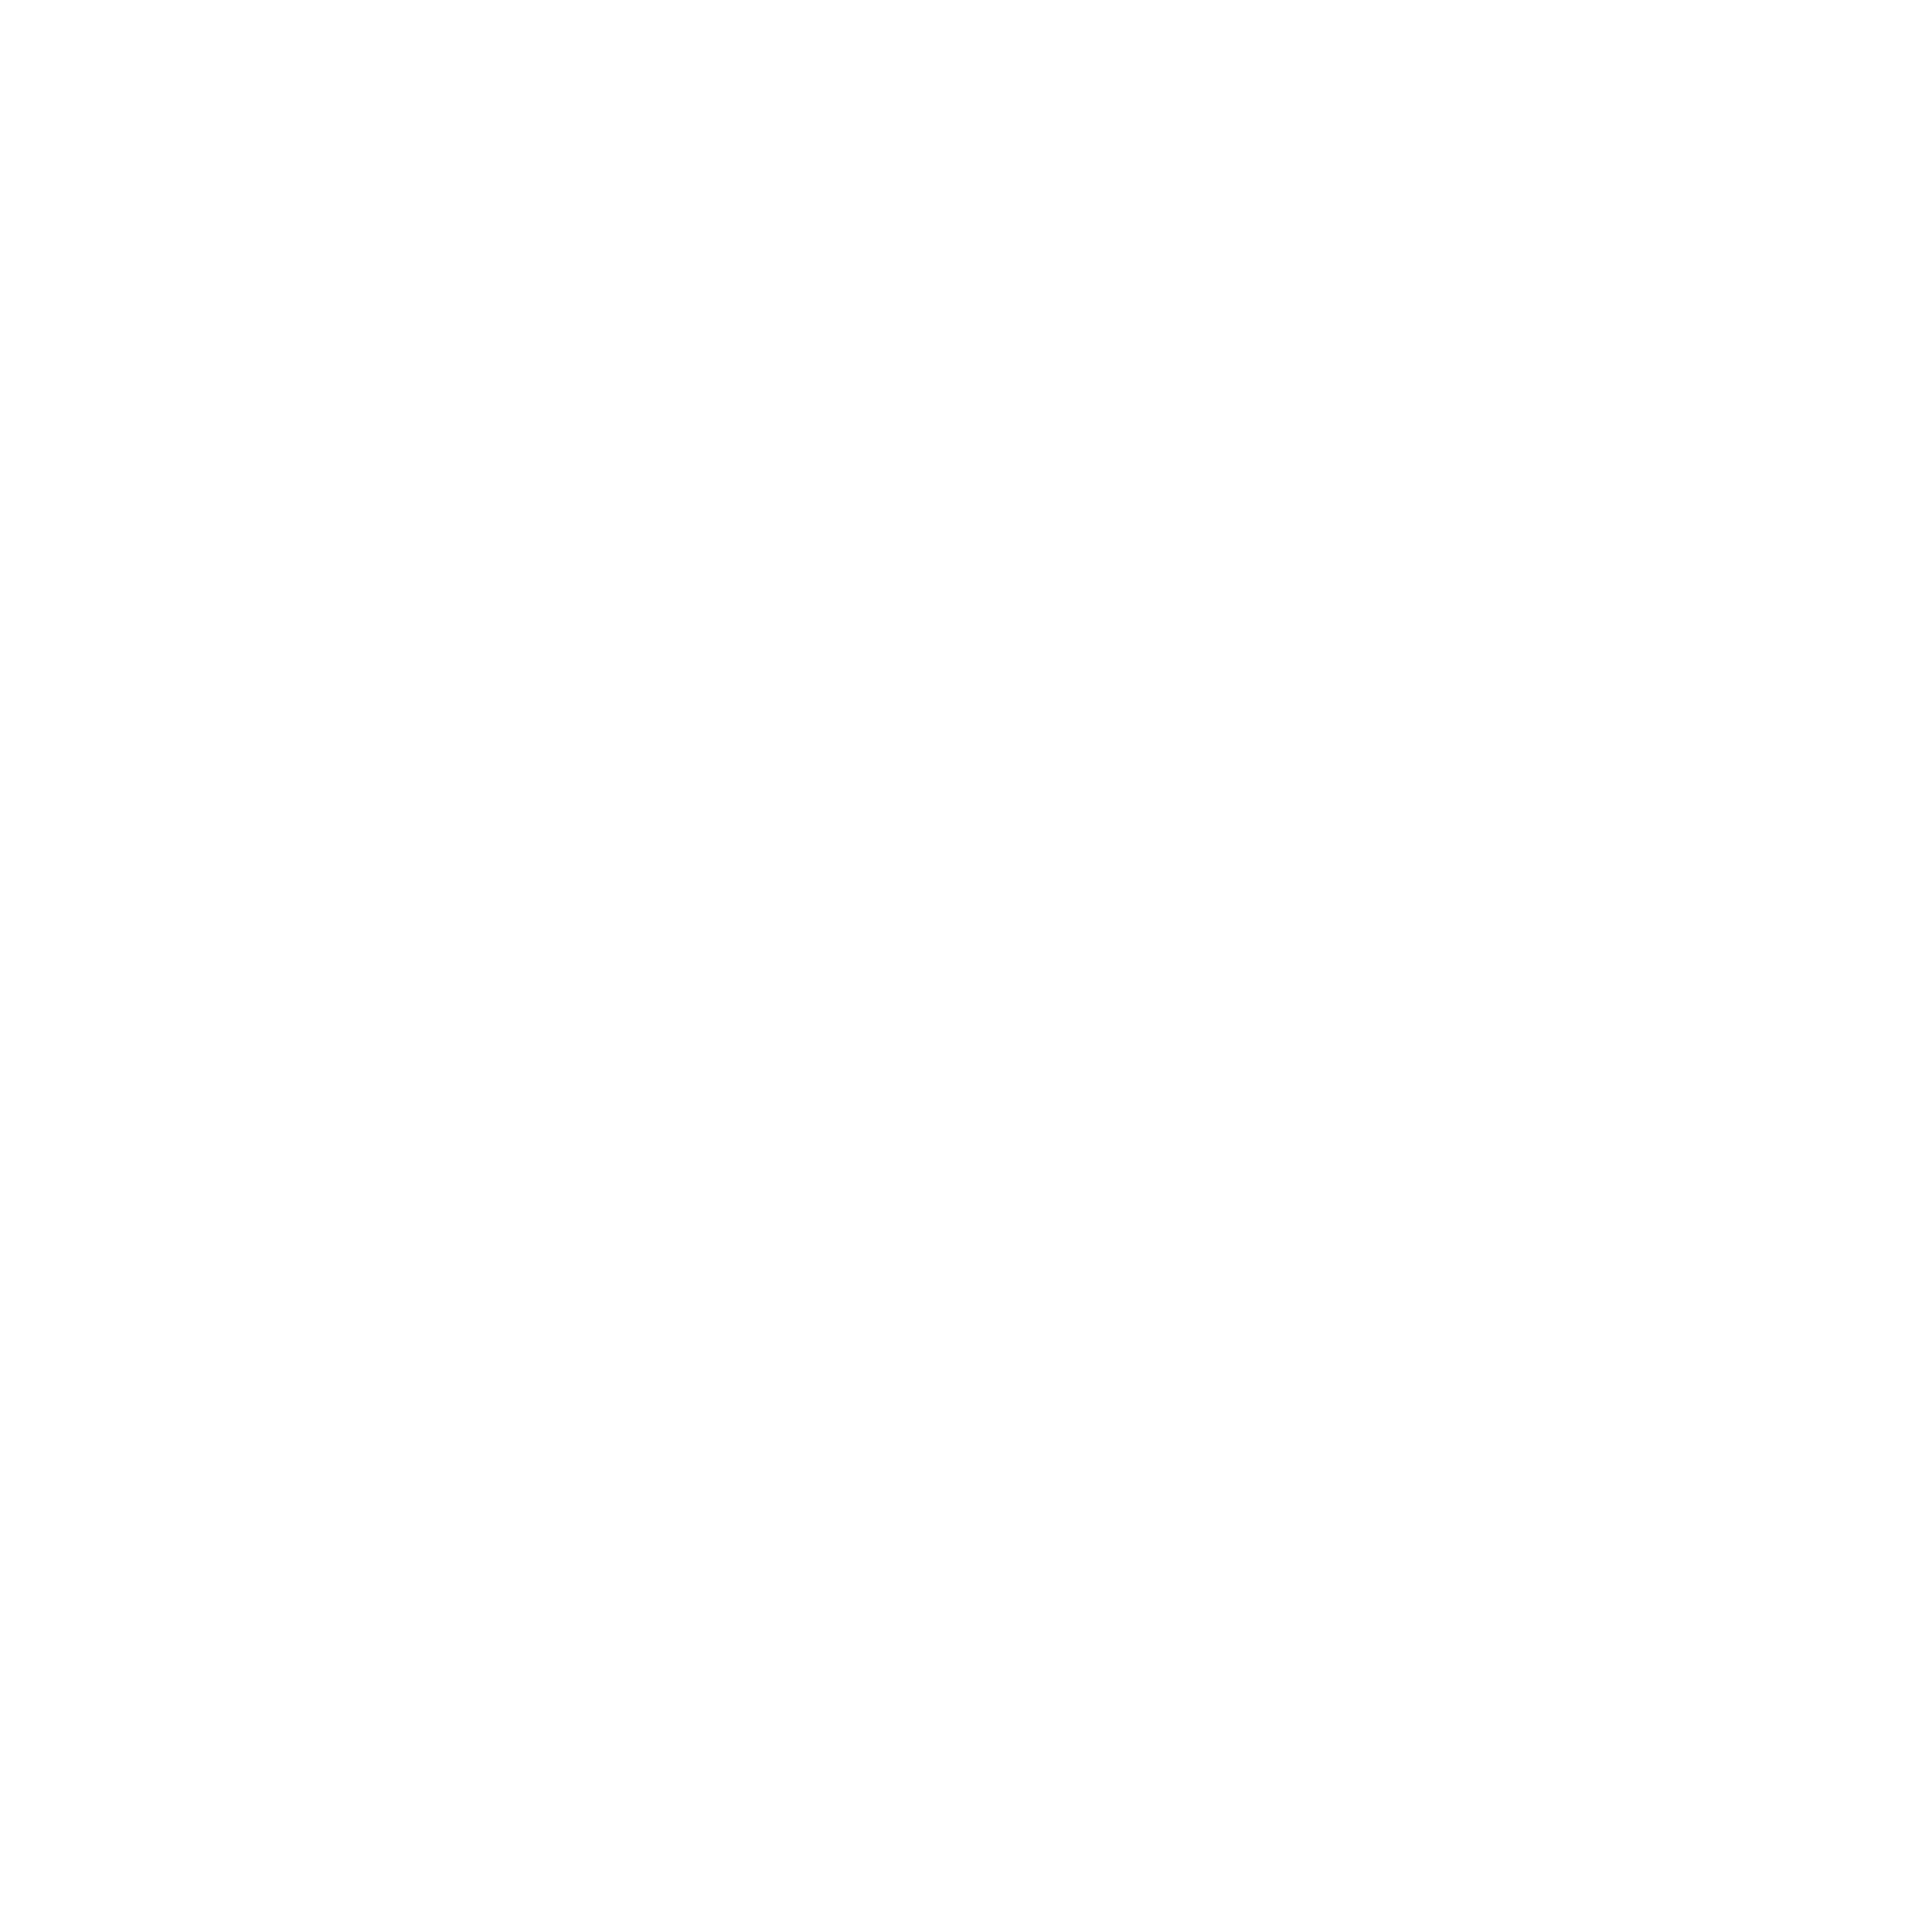

In [337]:
G_U = G_U_copy

H_U = nx.subgraph(G_U, list(partition_dict[0]))
H_U

largest_degree_labels = []
largest_degree_nodes = sorted(H_U.degree, key=lambda x: x[1], reverse=True)[:3]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])

plt.style.use('default')

network, config = nw.visualize(H_U, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 20)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 10)



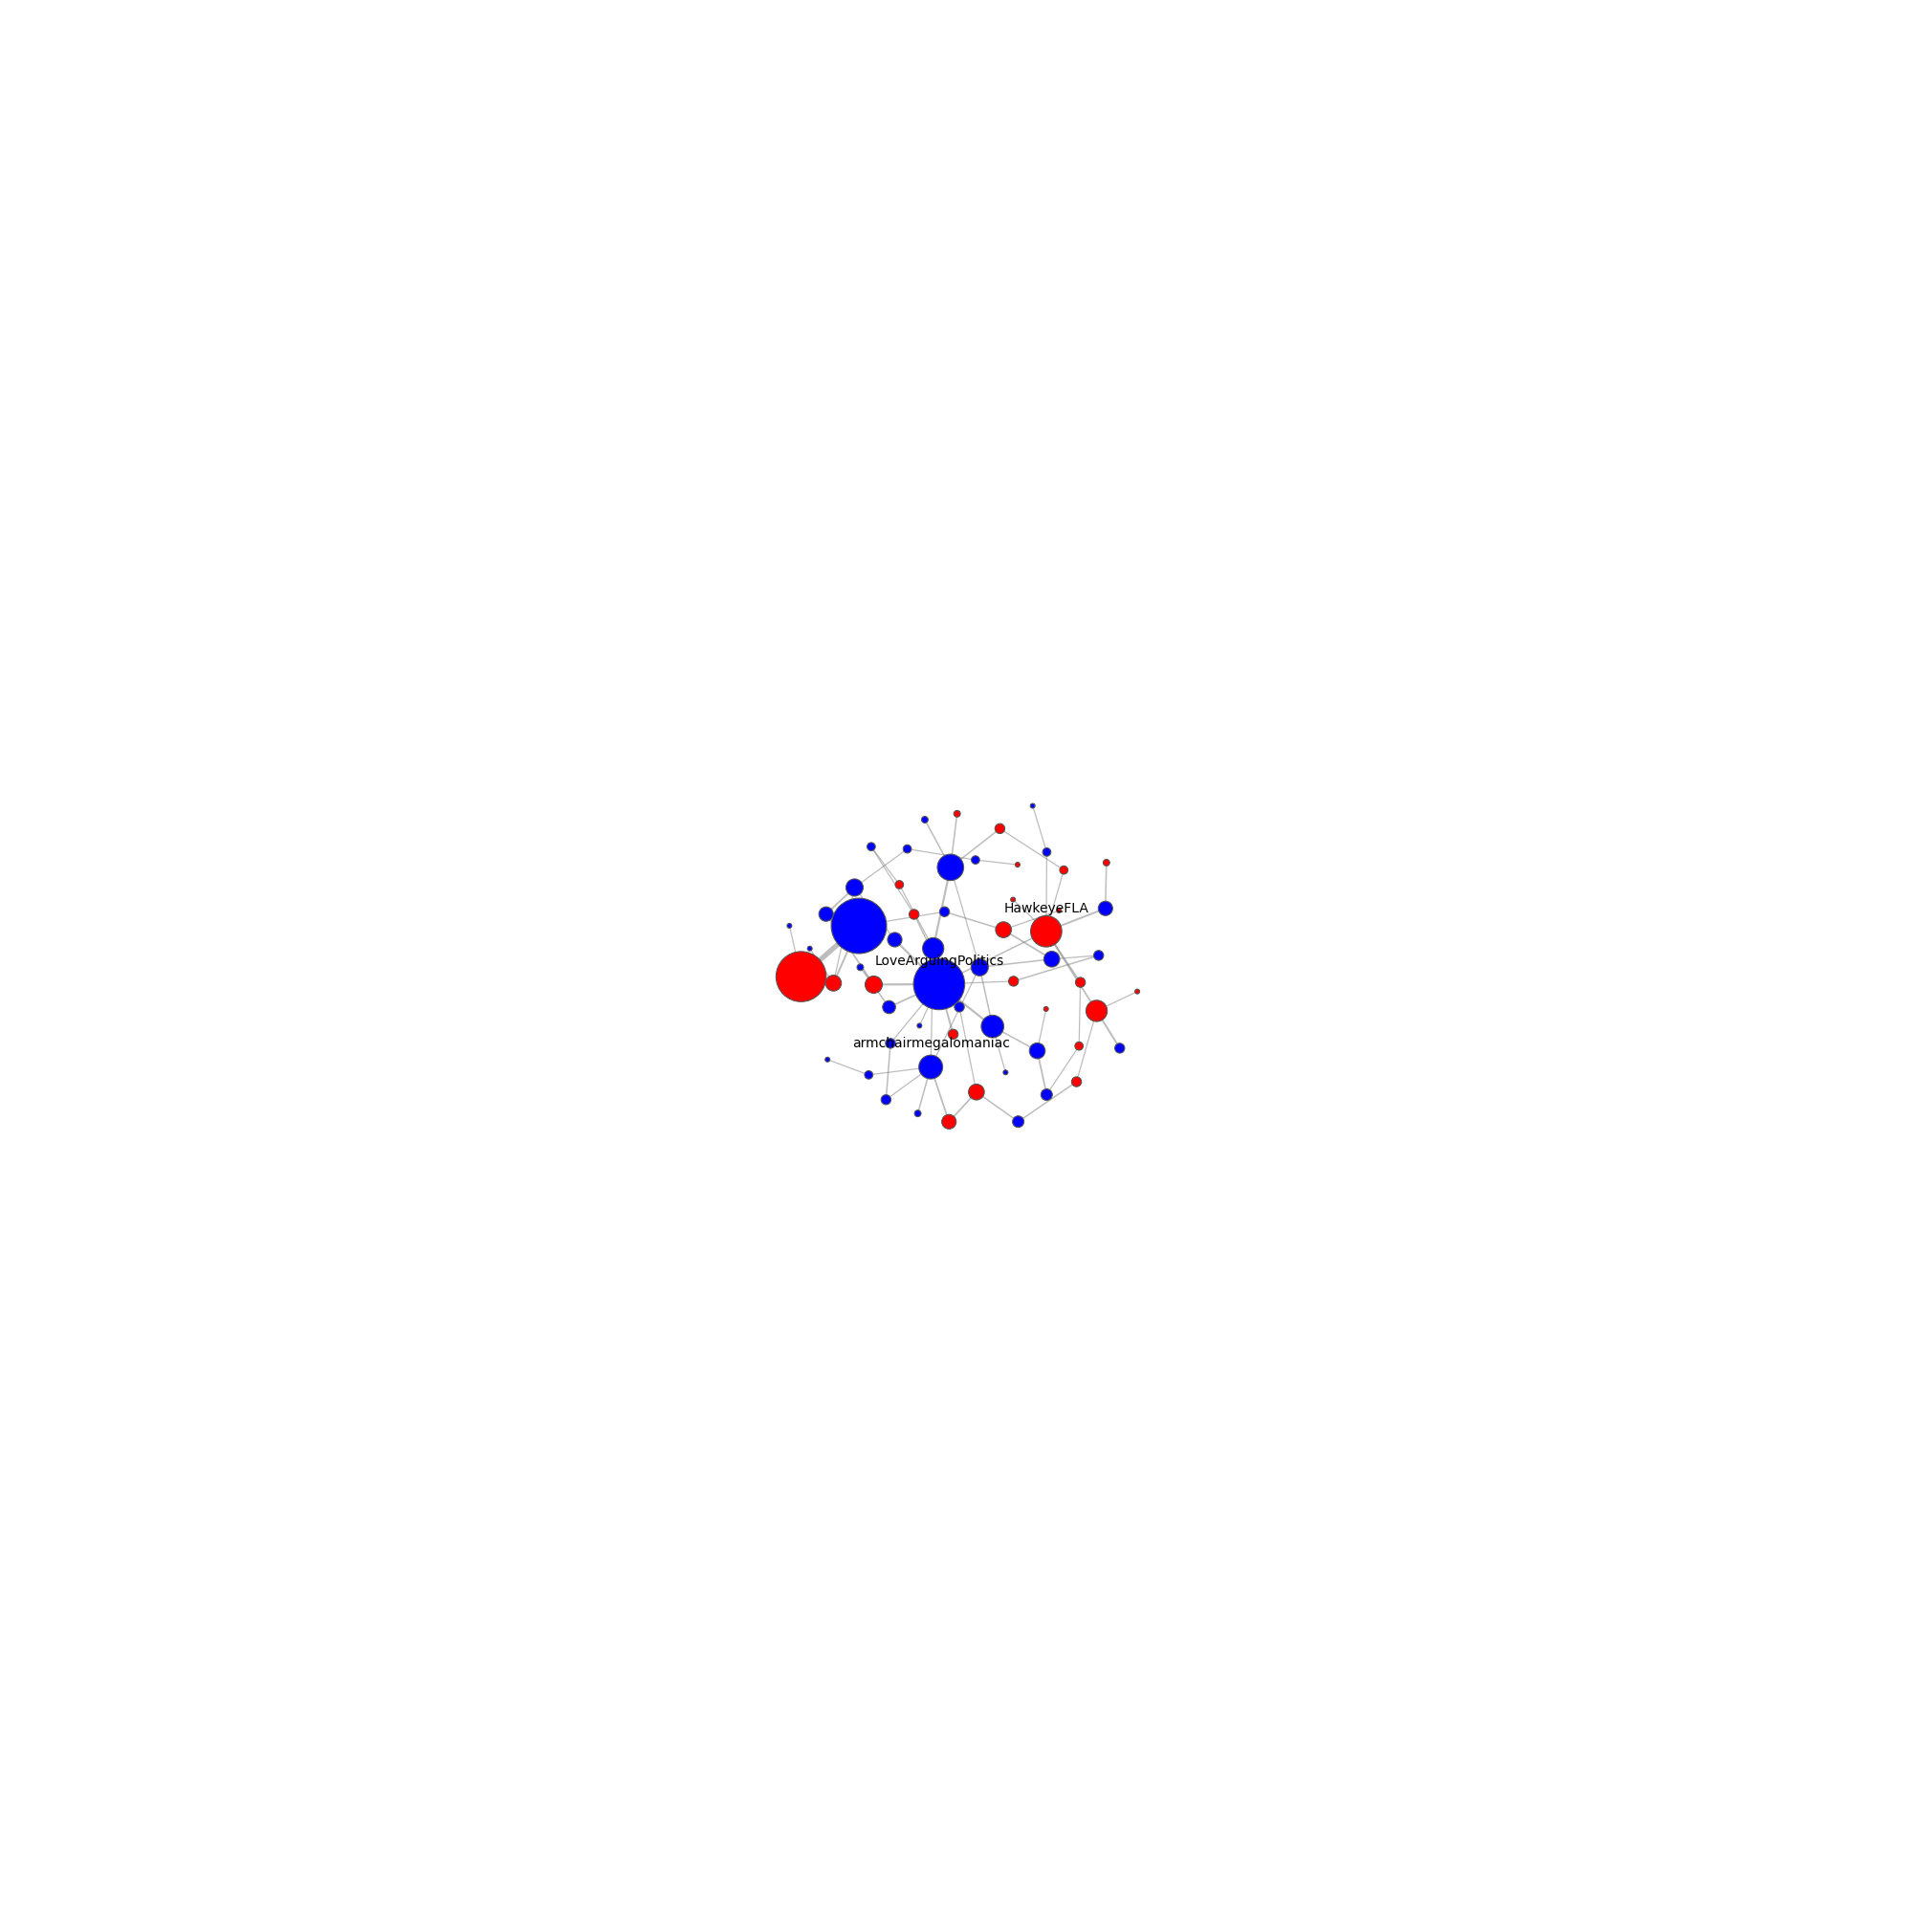

In [86]:
H_U_2 = nx.subgraph(G_U, list(partition_dict[1]))

largest_degree_labels = []
largest_degree_nodes = sorted(H_U_2.degree, key=lambda x: x[1], reverse=True)[:3]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])

plt.style.use('default')

network, config = nw.visualize(H_U_2, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 20)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 10)


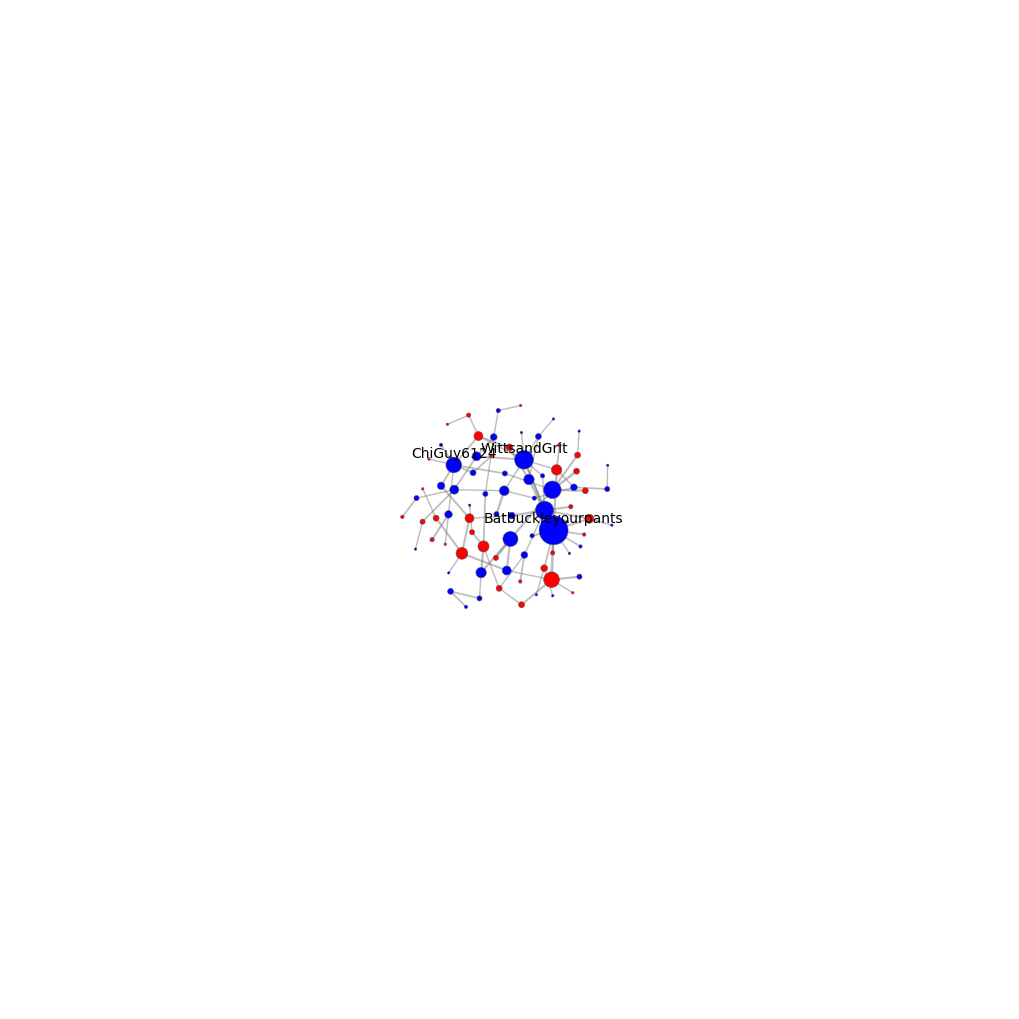

In [88]:
H_U_3 = nx.subgraph(G_U, list(partition_dict[2]))

largest_degree_labels = []
largest_degree_nodes = sorted(H_U_3.degree, key=lambda x: x[1], reverse=True)[:3]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])

plt.style.use('default')

network, config = nw.visualize(H_U_3, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 10)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 10)


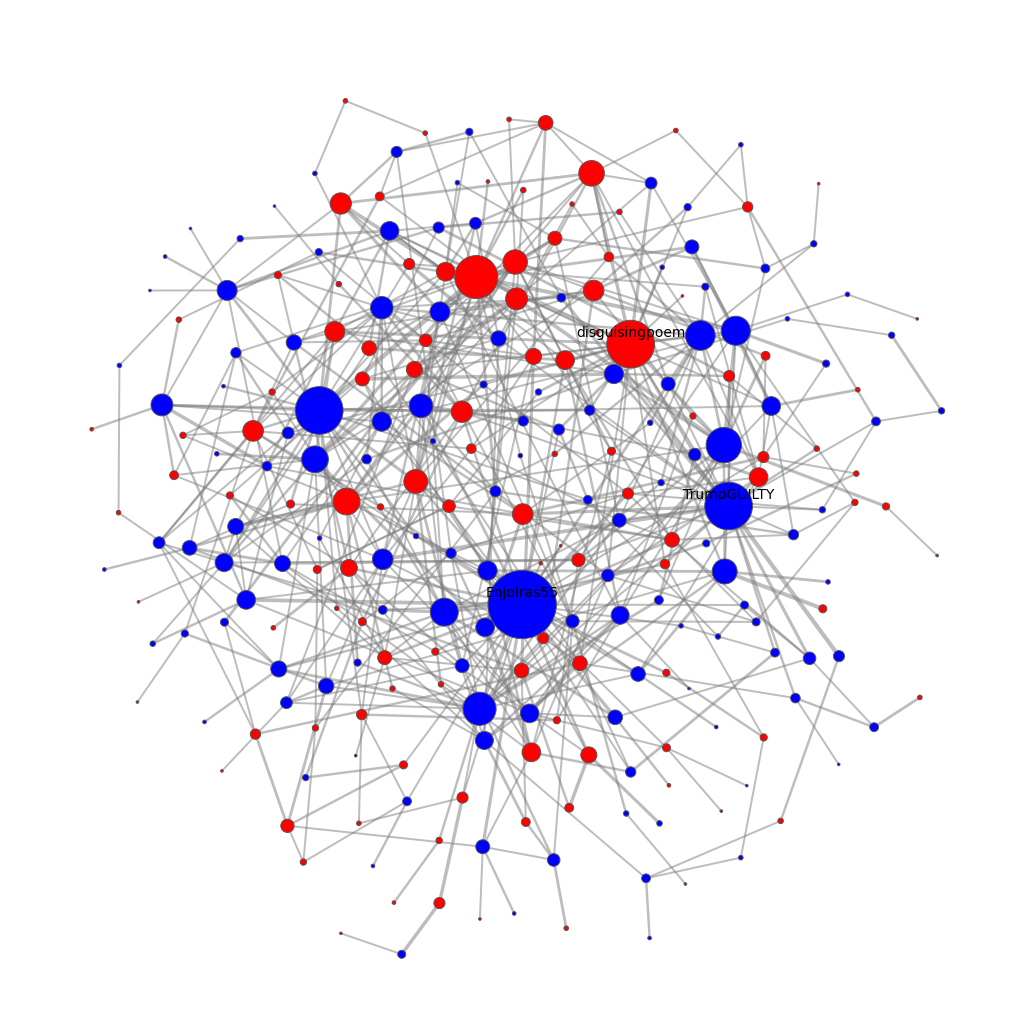

In [90]:
H_U_20 = nx.subgraph(G_U, list(partition_dict[19]))

largest_degree_labels = []
largest_degree_nodes = sorted(H_U_20.degree, key=lambda x: x[1], reverse=True)[:3]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])

plt.style.use('default')

network, config = nw.visualize(H_U_20, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 10)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 10)